In [1]:
# import module
import pandas as pd
import numpy as np
import os
import datetime
from pandas import Series,DataFrame
import glob
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.linear_model import OLS
import statsmodels.formula.api as sm
import time
import warnings
from patsy import dmatrices
warnings.filterwarnings(action='ignore')
%matplotlib inline

font_name = mpl.font_manager.FontProperties(fname='C:/Windows/Fonts/malgunbd.ttf').get_name()
mpl.rc('font', family=font_name)
mpl.rcParams['axes.unicode_minus'] = False

# Exploratory Data Analysis(EDA)

인천(운서), 철산(광명), 중2동(부천), 시흥(정왕, 대야), 안산(고잔, 원시), 의왕(고천), 군포(산본), 수원(광교, 고색), 당진(송산면)을 바탕으로 

지역별 EDA 진행

In [2]:
df = pd.read_csv('D:/data/row_final.csv',encoding='UTF-8')
df = df[['site', 'date', 'so2', 'co', 'o3', 'no2', 'pm10', 'pm25', 'temp',
       'wind_speed', 'wind_direction', 'rain_yn', 'humid']]
df = df.iloc[:, [0,1,2,3,4,5,6,7,8,9,10,11,12]]
df.loc[df['temp'] <= -30, 'temp' ] = np.float("nan")
df['rain_yn'] = df['rain_yn'].apply(lambda x: x if x==0 else 1)
df.isnull().sum()

site                   0
date                   0
so2                 7075
co                  7775
o3                  7290
no2                 8656
pm10               11499
pm25               12351
temp                9657
wind_speed         13416
wind_direction     13829
rain_yn                0
humid             108718
dtype: int64

충남 데이터 load

In [3]:
df1 = pd.read_csv('D:/data/chungnam_pm_weather.csv')
df1.rename(columns = {'weather':'temp'},inplace=True)
df1['rain_yn'] = df1['rain_yn'].apply(lambda x: x if x==0 else 1)
df1.isnull().sum()

date                 0
site                 0
so2               1258
co                1326
o3                1242
no2               1517
pm10              1576
pm25              1920
temp                85
wind_direction      95
wind_speed          94
rain_yn              0
humid               84
dtype: int64

In [4]:
df = pd.concat([df,df1])
df = df[['date','site','co','no2','o3','so2','pm10','pm25','temp','wind_direction','wind_speed','rain_yn','humid']]

In [5]:
df['site'].unique().tolist()

['광교동',
 '중2동',
 '대야동',
 '산본동',
 '철산동',
 '고색동',
 '운서',
 '시화산단',
 '원시동',
 '고천동',
 '고잔동',
 '송산면']

## 지역 별 데이터 분리  
반월시화(시흥), 반월시화(안산), 대야(시흥), 고잔(안산), 고천(의왕), 산본(군포) , 고색(수원) , 광교(수원), 당진(충남) 지역 분리하여 EDA 진행

### 파생변수 추가

In [6]:
def date_split(df) : # 날짜 Split
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M')
    df['ymd'] = [d.date() for d in df['date']]
    df['month'] = [d.month for d in df['date']]
    df['month'] = df['month'].astype(str)
    df['time'] = [d.time() for d in df['date']]
    df['time'] = df['time'].apply(lambda x: x.strftime('%H'))
    df['md'] = df['ymd'].apply(lambda x: x.strftime('%m-%d'))
    df['weekday'] =df['date'].apply(lambda x: x.strftime('%A'))

    
def season(x): # 계절 파생변수
    if '05-31'>= x>='03-01':
        return('봄')
    elif '08-31' >=x >= '06-01':
        return('여름')
    elif '11-30' >= x >= '09-01':
        return('가을')
    else: return('겨울')

def categorical_PM(x): # WHO 기준 PM2.5
    if 8>= x>=0:
        return('최고')
    elif 15 >= x >= 9 :
        return('좋음')
    elif 20 >=x >= 16:
        return('양호')
    elif 25 >=x >= 21:
        return('보통')
    elif 37 >=x >= 26:
        return('나쁨')
    elif 50 >=x >= 38:
        return('상당히 나쁨')
    elif 75 >=x >= 51:
        return('매우 나쁨')
    else: return('최악')     

In [7]:
pm=df.copy()
date_split(pm)
pm['season'] = pm['md'].apply(season)
pm['PM_categorical'] = pm['pm25'].apply(categorical_PM)

### 지역 이름 변경

In [8]:
site_list = ['대야동', '시화산단', '고잔동', '원시동', '고천동', '산본동', '고색동', '광교동']
change_list = ['시흥-대야', '반월시화(시흥)', '안산-고잔', '반월시화(안산)', '의왕', '군포' , '수원' , '광교']
for i,j in zip(site_list,change_list):
    pm['site'].replace(i,j,inplace=True)

In [9]:
pm =pm[pm['site'].isin(change_list)]
pm['site'].unique().tolist()

['광교', '시흥-대야', '군포', '수원', '반월시화(시흥)', '반월시화(안산)', '의왕', '안산-고잔']

In [10]:
column_site = ['gwanggyo','daeya','gunpo' , 'suwon', 'sihwa','wonsi','gocheon','gojan']
site_KR = pm['site'].unique().tolist()
for site, column in zip(column_site,site_KR):
    globals()[f'{site}']= pm[pm['site']==f'{column}']

### 광교, 대야, 산본, 고천, 철산, 중2동은 습도 측정이 되지 않았음  
### 해당 지역은 습도 제거하고 진행

In [11]:
gwanggyo.drop('humid',axis=1,inplace=True)
daeya.drop('humid',axis=1,inplace=True)
gunpo.drop('humid',axis=1,inplace=True)
gocheon.drop('humid',axis=1,inplace=True)

In [12]:
for site in column_site:
    globals()[f'{site}'].fillna(method='ffill',inplace=True)
    globals()[f'{site}'].dropna(inplace=True)

In [13]:
site_list = ['시화산단', '대야동', '원시동', '고잔동', '고천동', '산본동', '고색동', '광교동']
change_list = ['반월시화(시흥)', '반월시화(안산)', '시흥-대야', '안산-고잔', '의왕', '군포' , '수원' , '광교']

for i,j in zip(site_list,change_list):
    pm['site'].replace(i,j,inplace=True)

In [14]:
for i in column_site:
    date_split(globals()[f'{i}'])
    globals()[f'{i}']['season'] = globals()[f'{i}']['md'].apply(season)
    globals()[f'{i}']['PM_categorical'] = globals()[f'{i}']['pm25'].apply(categorical_PM)

In [15]:
pm['PM_categorical'].value_counts()

좋음        27541
나쁨        24618
최고        20521
양호        19607
보통        15786
상당히 나쁨    13043
최악        12902
매우 나쁨      9995
Name: PM_categorical, dtype: int64

## 도시별 미세먼지 평균  
전체 평균, 연평균 나누어 진행

In [17]:
pm_mean = pm.groupby(['site'])['pm25'].mean().reset_index(drop=False)
pm_mean= pm_mean.sort_values(['pm25'],ascending=False)
pm_mean

site       pm25
2  반월시화(시흥)  31.723047
5     시흥-대야  30.378877
6     안산-고잔  26.210672
3  반월시화(안산)  24.998434
4        수원  24.814770
1        군포  24.732215
0        광교  24.519734
7        의왕  24.099372

<Figure size 1656x1440 with 0 Axes>

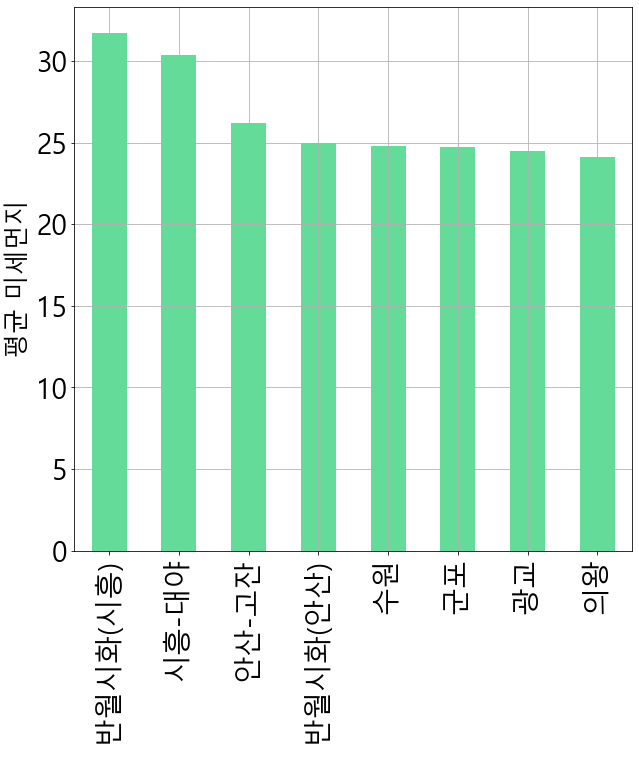

In [18]:
plt.figure(figsize=(23,20))
pm_mean.plot(kind='bar', x='site',y='pm25',grid=True, figsize=(10,10),color="#64DB99", legend=None)
plt.xlabel(' ')
plt.ylabel('평균 미세먼지',size=25)
plt.tick_params(labelsize=28)
plt.show()

In [19]:
pm_year = pm.copy()
pm_year['date'] = pd.to_datetime(pm_year['date'], format= '%Y-%m-%d %H:%M')
pm_year['year'] = [d.year for d in pm_year['date']]
pm_year.head()

date      site   co    no2     o3    so2  pm10  pm25  temp  \
0 2017-12-01        광교  0.3  0.017  0.034  0.003  10.0   2.0  -4.1   
2 2017-12-01     시흥-대야  0.4  0.016  0.027  0.004  20.0   5.0  -2.5   
3 2017-12-01        군포  0.3  0.012  0.026  0.004  13.0  12.0  -3.6   
5 2017-12-01        수원  0.5  0.023  0.022  0.004  10.0  15.0  -3.8   
7 2017-12-01  반월시화(시흥)  0.4  0.017  0.030  0.005  21.0  13.0  -4.6   

   wind_direction  ...  rain_yn  humid         ymd month time     md weekday  \
0            81.1  ...      0.0    NaN  2017-12-01    12   00  12-01  Friday   
2             3.6  ...      0.0    NaN  2017-12-01    12   00  12-01  Friday   
3           291.1  ...      0.0    NaN  2017-12-01    12   00  12-01  Friday   
5           335.3  ...      0.0   39.0  2017-12-01    12   00  12-01  Friday   
7             4.5  ...      0.0   43.6  2017-12-01    12   00  12-01  Friday   

  season PM_categorical  year  
0     겨울             최고  2017  
2     겨울             최고  2017  
3     겨울             좋음  2017  
5     겨울             좋음  2017  
7     겨울             좋음  2017  

[5 rows x 21 columns]

In [20]:
pm_year_mean = pm_year.groupby(['year','site'])['pm25'].mean().reset_index(drop=False)
pm_year_mean= pm_year_mean.sort_values(['pm25'],ascending=False)
year_value = pm_year_mean['year'].unique().tolist()

<Figure size 1656x1440 with 0 Axes>

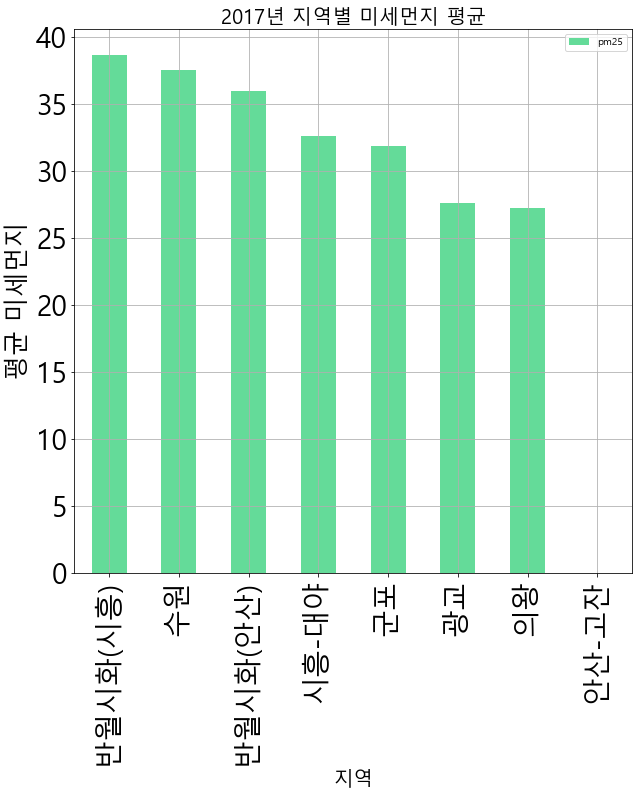

<Figure size 1656x1440 with 0 Axes>

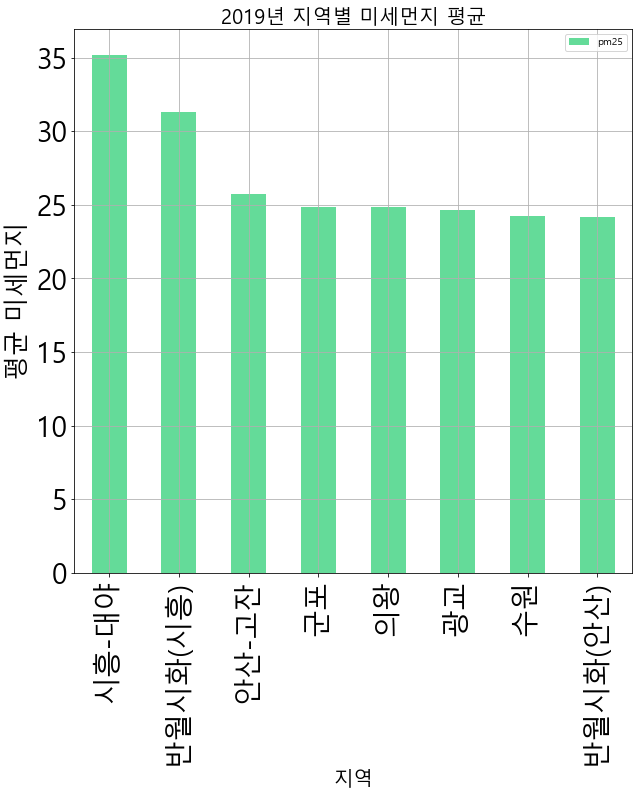

<Figure size 1656x1440 with 0 Axes>

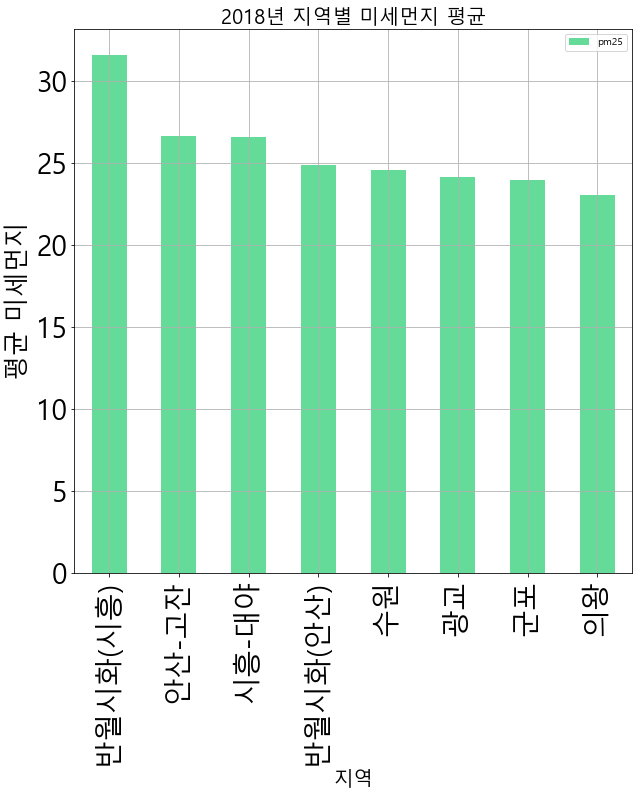

In [21]:
for i in year_value:
    data = pm_year_mean[pm_year_mean['year']==i] 
    plt.figure(figsize=(23,20))
    data.plot(kind='bar', x='site',y='pm25',grid=True, figsize=(10,10),color="#64DB99")
    plt.title(f"{i}년 지역별 미세먼지 평균",size=20)
    plt.xlabel('지역',size=20)
    plt.ylabel('평균 미세먼지',size=25)
    plt.tick_params(labelsize=28)
    # plt.savefig(r'D:/pm/plot_ratio.png', format='png')
    plt.show()

# BOXPLOT

### 계절 별 전체 BOXPLOT

pallette ['husl','dark','hls','pastel','bright','Paired']

In [22]:
site_list = pm_del['site'].unique().tolist()
PM_list = ['최고','좋음','양호','보통','나쁨','상당히 나쁨','매우 나쁨','최악']

(0, 100)

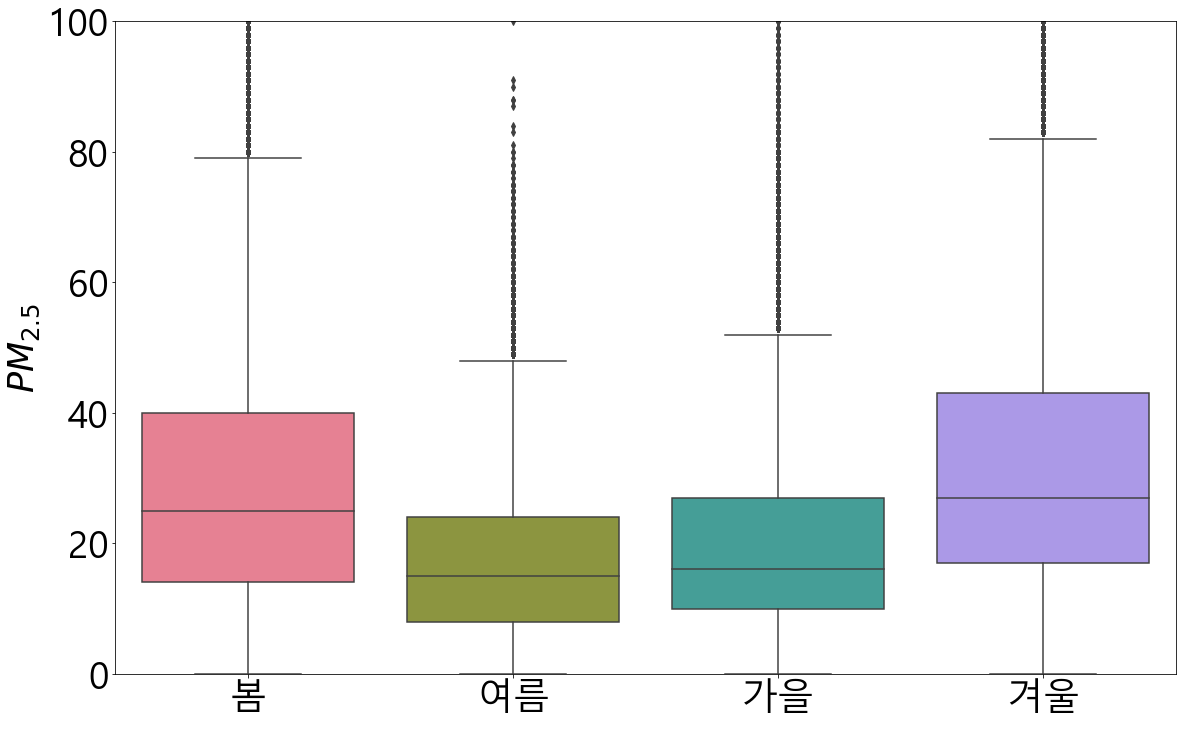

In [23]:
plt.figure(figsize=(19,12))
sns.boxplot(x="season", y="pm25",order=['봄','여름','가을','겨울'], palette='husl', width=0.8,data=pm_del)
plt.tick_params(labelsize=37)
# plt.title("계절별 미세먼지 BOXPLOT",size=35)
plt.xlabel(' ')
plt.ylabel('$PM_{2.5}$',size=35)
plt.ylim(0,100)

## 지역, 계절별 BOXPLOT

지역이 너무 많아(11개), (겨울, 봄), (여름, 가을)로 분할하여 EDA 진행

In [24]:
site_list = ['반월시화(시흥)','시흥-대야',  '안산-고잔', '반월시화(안산)', '의왕', '군포' , '수원' , '광교']
season_ss = pm[pm['season'].isin(['봄','여름'])]
season_fw = pm[pm['season'].isin(['가을','겨울'])]
season_ss = season_ss.sort_values(['season'])
season_fw = season_fw.sort_values(['season'])

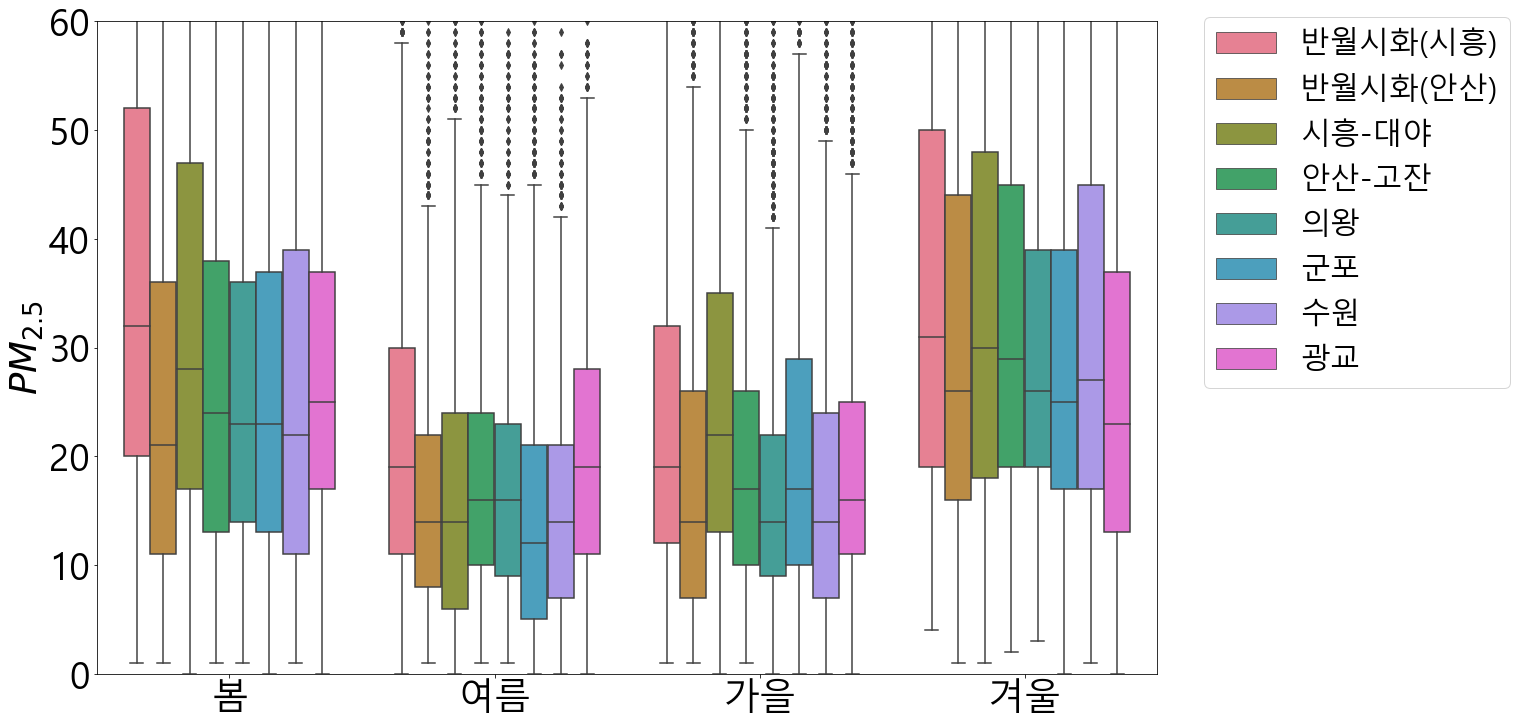

In [25]:
#계절별 BOXPLOT
site_list = ['반월시화(시흥)', '반월시화(안산)','시흥-대야',  '안산-고잔', '의왕', '군포' , '수원' , '광교']
plt.figure(figsize=(19,12))
sns.boxplot(x="season", y="pm25", hue='site' , order = ['봄', '여름', '가을','겨울'],
            palette='husl' ,hue_order=site_list, width=0.8,data=pm)
plt.tick_params(labelsize=37)
# plt.title("여름, 가을 미세먼지 BOXPLOT",size=35)
plt.xlabel('',size=30)
plt.ylabel('$PM_{2.5}$',size=37)
plt.ylim(0,60)
plt.legend(fontsize=30,bbox_to_anchor=(1.03, 1.03))

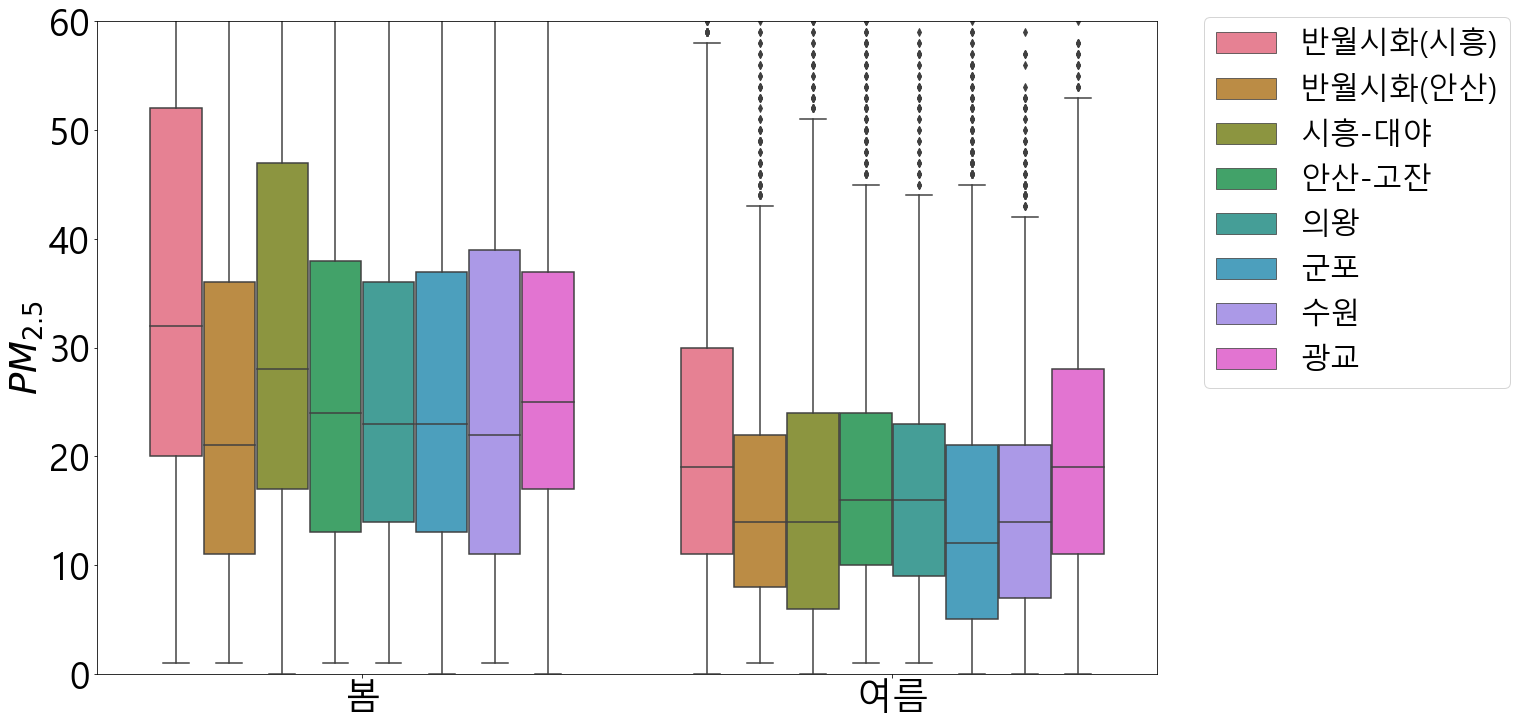

In [26]:
#계절별 BOXPLOT
plt.figure(figsize=(19,12))
ax=sns.boxplot(x="season", y="pm25", hue='site' ,palette='husl' ,hue_order=site_list, width=0.8,data=season_ss)
ax.tick_params(labelsize=37)
# plt.title("여름, 가을 미세먼지 BOXPLOT",size=35)
plt.xlabel('',size=30)
plt.ylabel('$PM_{2.5}$',size=37)
plt.ylim(0,60)
plt.legend(fontsize=30,bbox_to_anchor=(1.03, 1.03))

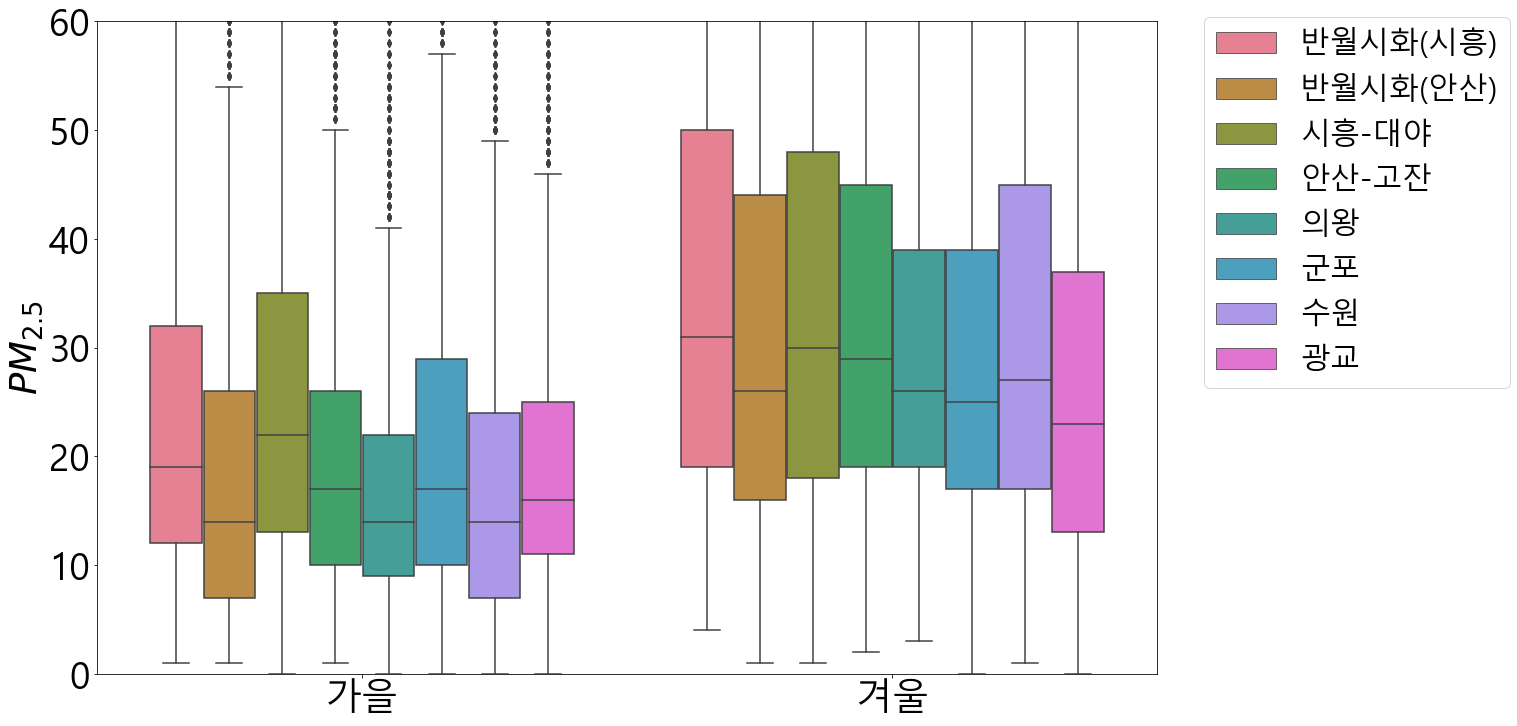

In [27]:
#계절별 BOXPLOT
plt.figure(figsize=(19,12))
ax=sns.boxplot(x="season", y="pm25", hue='site' ,palette='husl' ,hue_order=site_list, width=0.8,data=season_fw)
ax.tick_params(labelsize=37)
# plt.title("여름, 가을 미세먼지 BOXPLOT",size=35)
plt.xlabel('',size=30)
plt.ylabel('$PM_{2.5}$',size=37)
plt.ylim(0,60)
plt.legend(fontsize=30,bbox_to_anchor=(1.03, 1.03))

### 지역별 BOXPLOT

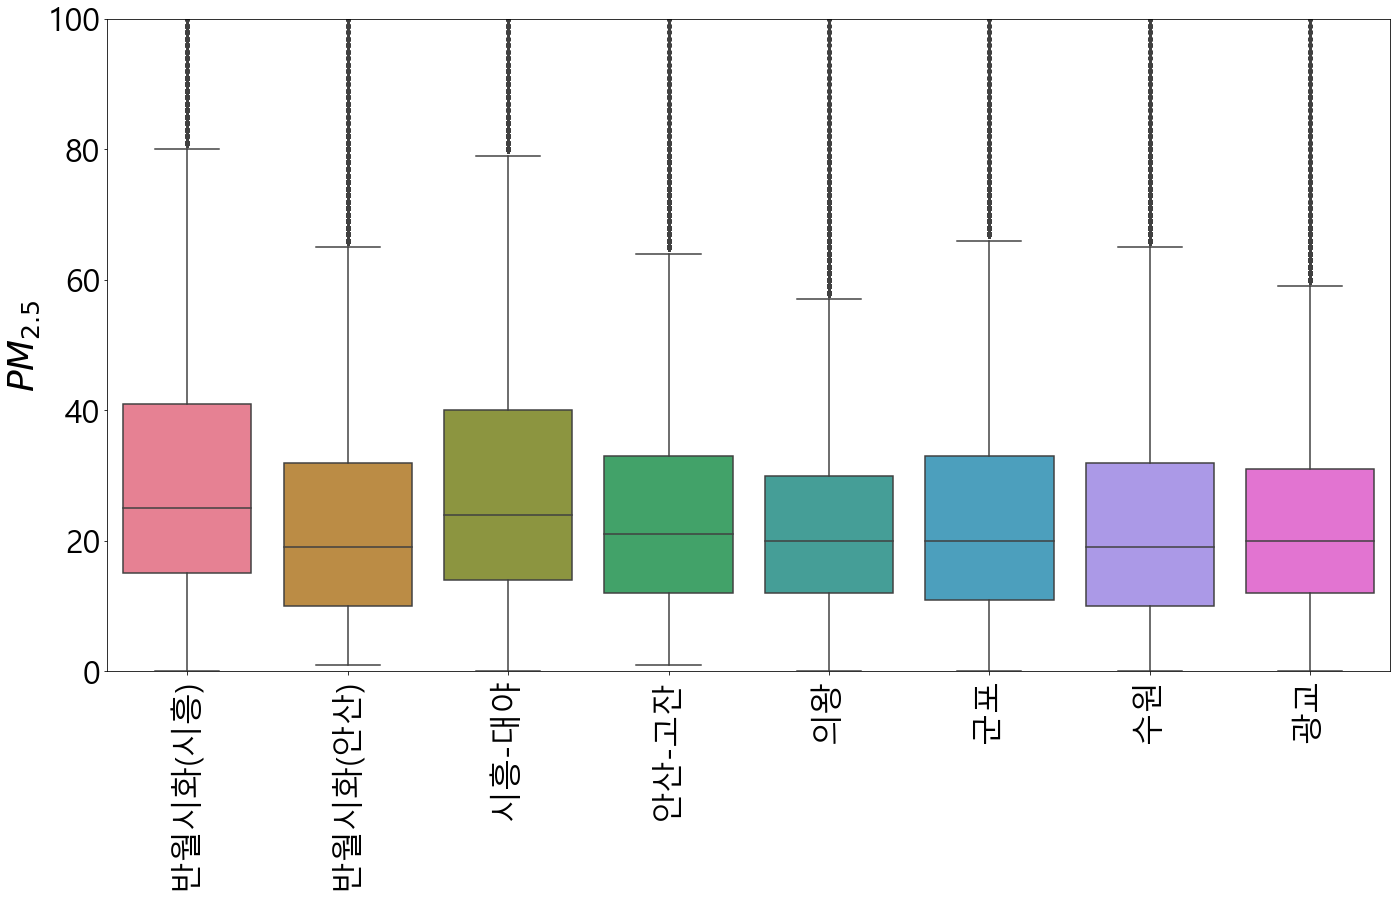

In [28]:
site_list = ['반월시화(시흥)', '반월시화(안산)','시흥-대야',  '안산-고잔', '의왕', '군포' , '수원' , '광교']
plt.figure(figsize=(23,12))
ax=sns.boxplot(x="site", y="pm25", palette='husl', width=0.8,data=pm_del,order = site_list)
ax.tick_params(labelsize=32)
plt.xlabel('',size=30)
plt.xticks(rotation=90)
plt.ylabel('$PM_{2.5}$',size=36)
plt.ylim(0,100)

# plt.savefig(r'D:/pm/boxplot1.png', format='png')
plt.show()

### 지역 별 미세먼지 8단계 분류 Countplot

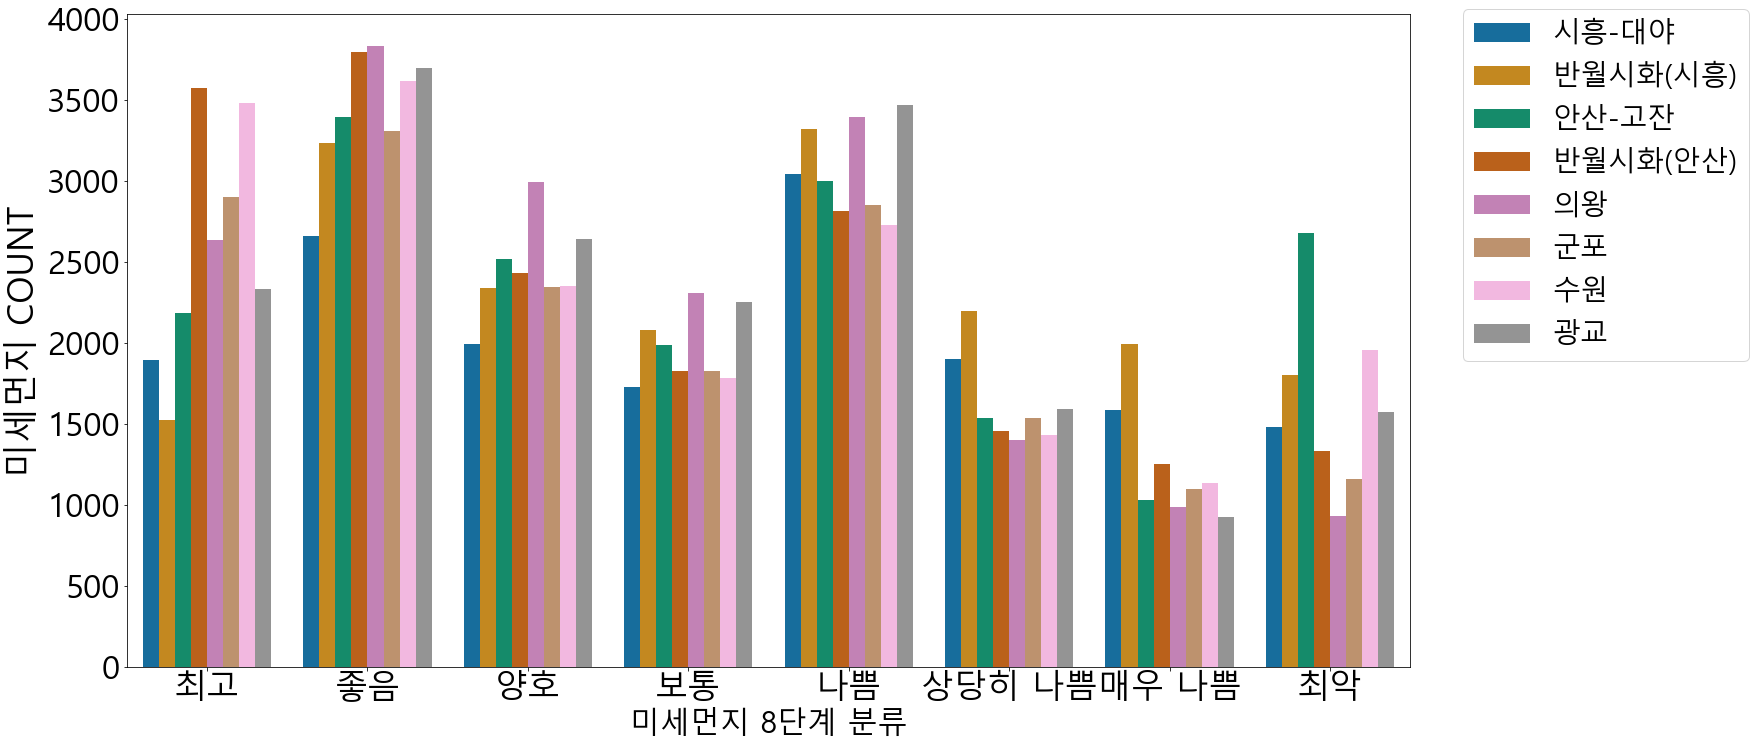

In [29]:
site_list = ['시흥-대야', '반월시화(시흥)', '안산-고잔', '반월시화(안산)', '의왕', '군포' , '수원' , '광교']
PM_list = ['최고','좋음','양호','보통','나쁨','상당히 나쁨','매우 나쁨','최악']
plt.figure(figsize=(23,12))
ax=sns.countplot(x="PM_categorical", hue='site',data=pm_del, order= PM_list, palette='colorblind', hue_order=site_list)
ax.tick_params(labelsize=33)
# plt.title(" 미세먼지 8단계 분류 COUNT",size=25)
plt.xlabel('미세먼지 8단계 분류',size=30)
plt.ylabel('미세먼지 COUNT',size=35)
plt.legend(fontsize=28, bbox_to_anchor=(1.03, 1.03))
# plt.savefig(r'D:/pm/plot_count.png', format='png')
plt.show()

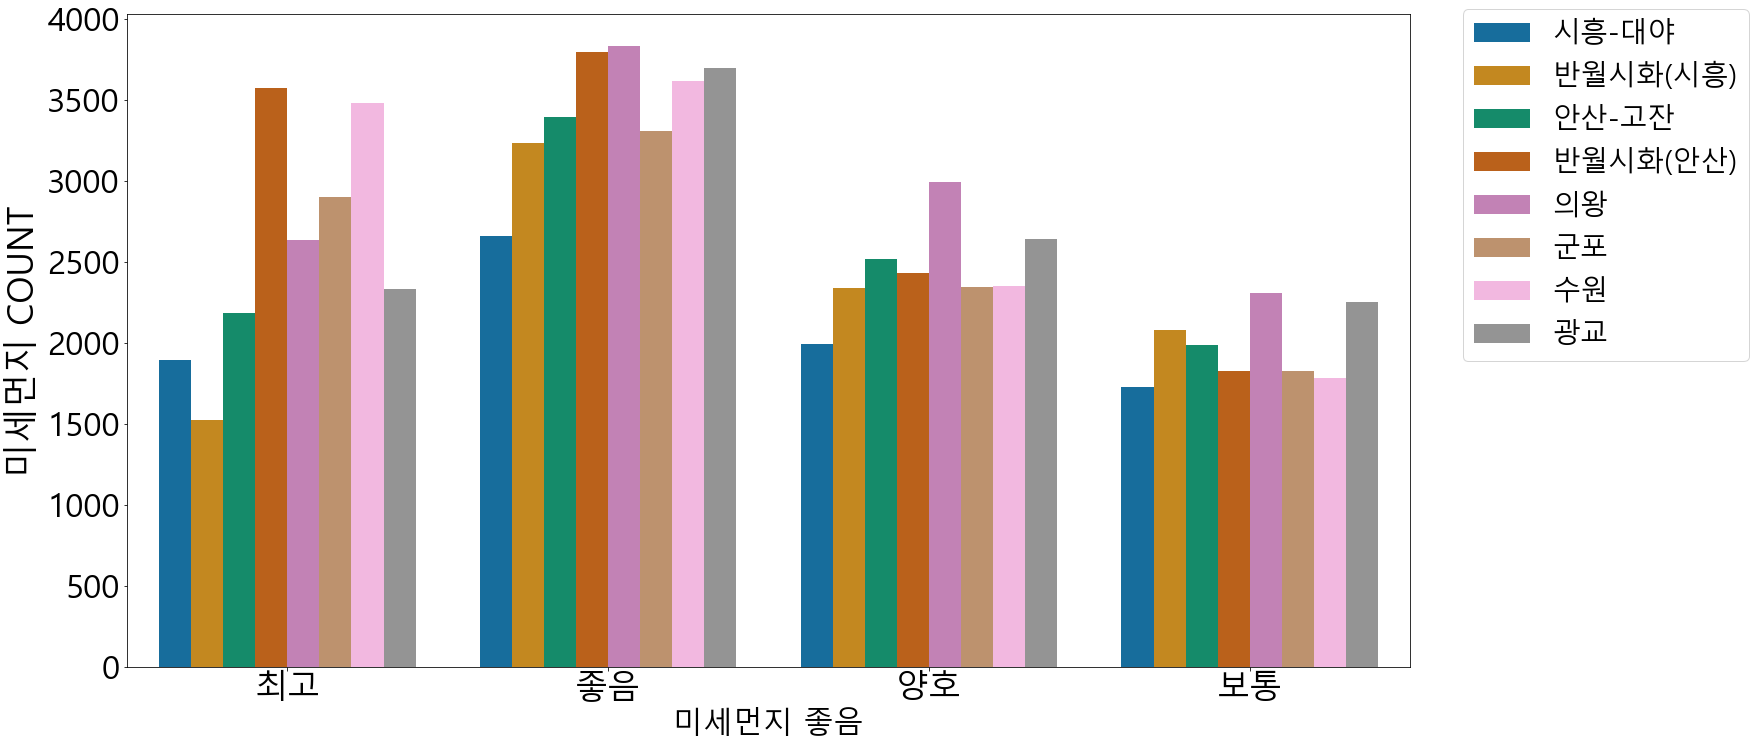

In [30]:
PM_good_list = ['최고','좋음','양호','보통']
plt.figure(figsize=(23,12))
ax=sns.countplot(x="PM_categorical", hue='site',data=pm, palette='colorblind', order= PM_good_list, hue_order=site_list)
ax.tick_params(labelsize=33)
# plt.title(" 미세먼지 8단계 분류 COUNT",size=25)
plt.xlabel('미세먼지 좋음',size=30)
plt.ylabel('미세먼지 COUNT',size=35)
plt.legend(fontsize=28, bbox_to_anchor=(1.03, 1.03))
# plt.savefig(r'D:/pm/plot_count.png', format='png')
plt.show()

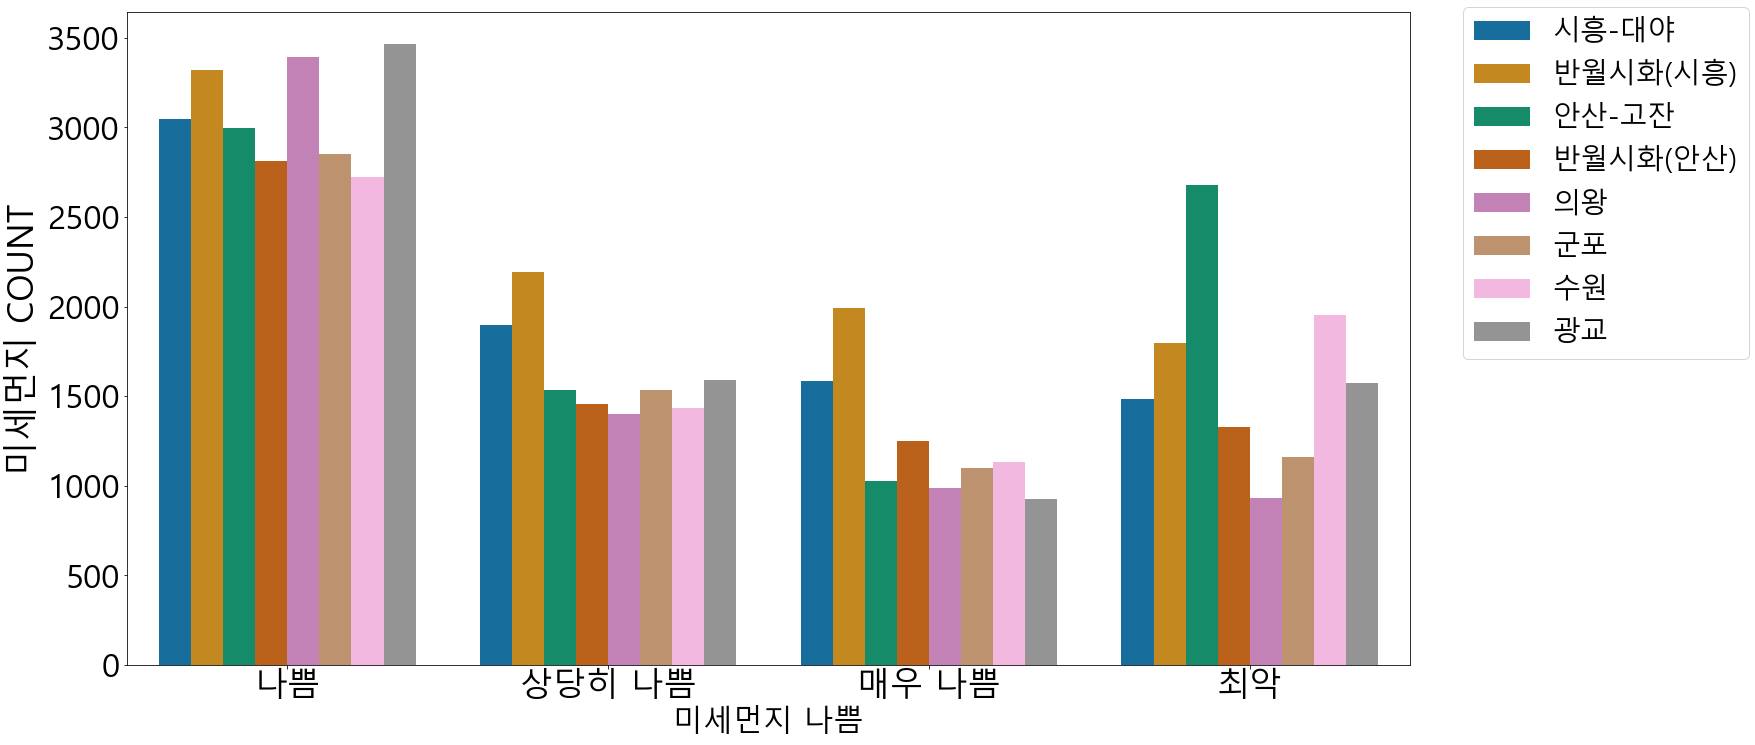

In [31]:
PM_bad_list = ['나쁨','상당히 나쁨','매우 나쁨','최악']
plt.figure(figsize=(23,12))
ax=sns.countplot(x="PM_categorical", hue='site',data=pm, palette='colorblind',order= PM_bad_list, hue_order=site_list)
ax.tick_params(labelsize=33)
# plt.title(" 미세먼지 8단계 분류 COUNT",size=25)
plt.xlabel('미세먼지 나쁨',size=30)
plt.ylabel('미세먼지 COUNT',size=35)
plt.legend(fontsize=28, bbox_to_anchor=(1.03, 1.03))
# plt.savefig(r'D:/pm/plot_count.png', format='png')
plt.show()

### 지역 별 미세먼지 8단계 분류 Lineplot

In [32]:
pm_8 = pm_del.groupby(['site','PM_categorical'])['pm25'].count().reset_index(drop=False)
pm_8

site PM_categorical  pm25
0    광교             나쁨  3468
1    광교          매우 나쁨   924
2    광교             보통  2253
3    광교         상당히 나쁨  1592
4    광교             양호  2640
..  ...            ...   ...
59   의왕         상당히 나쁨  1399
60   의왕             양호  2993
61   의왕             좋음  3835
62   의왕             최고  2635
63   의왕             최악   434

[64 rows x 3 columns]

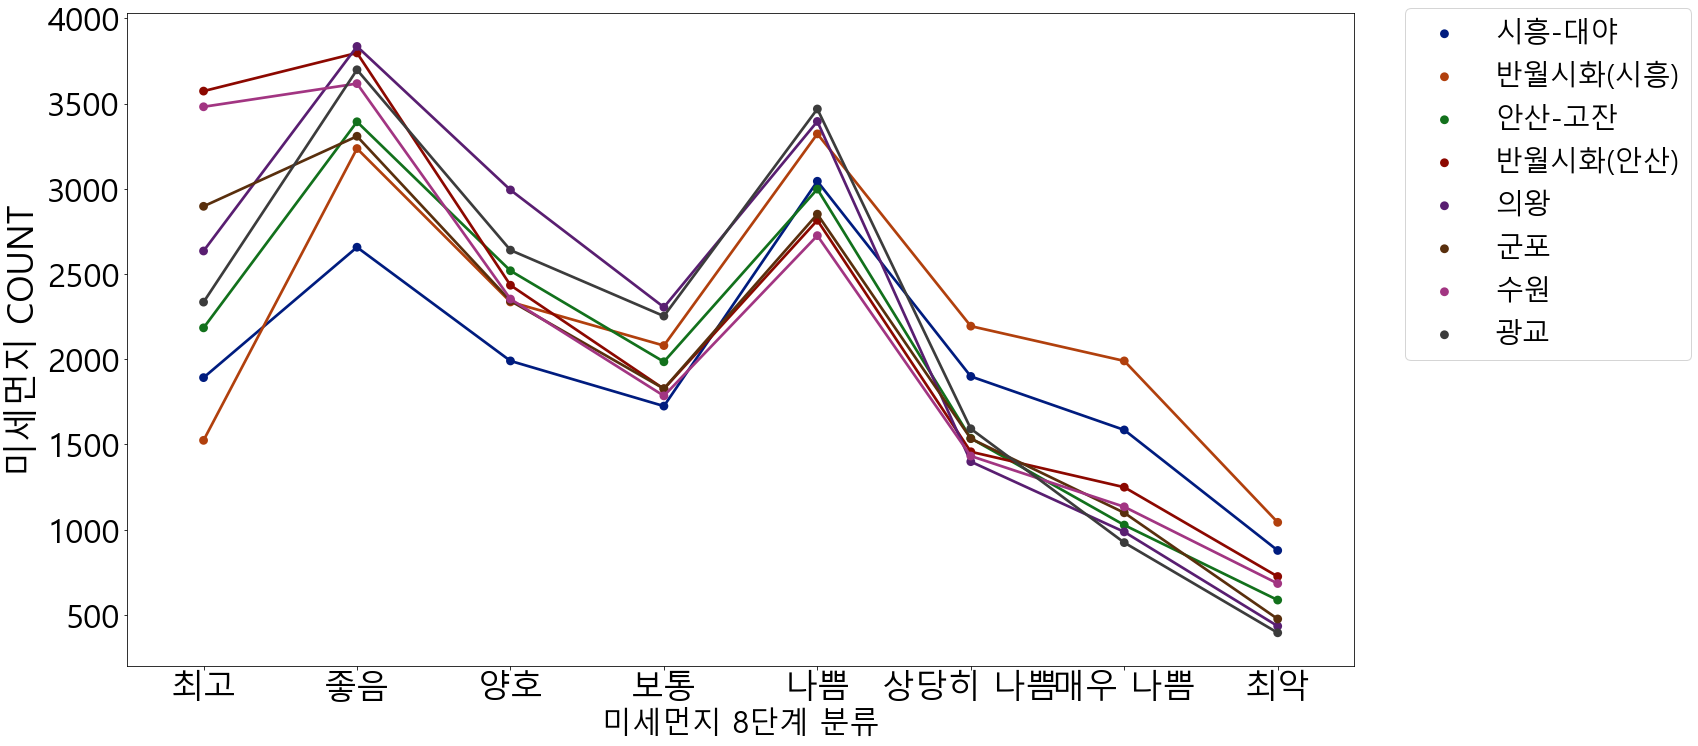

In [33]:
PM_list = ['최고','좋음','양호','보통','나쁨','상당히 나쁨','매우 나쁨','최악']
plt.figure(figsize=(22,12))
sns.pointplot(x="PM_categorical", y='pm25',hue='site',data=pm_8, order= PM_list, hue_order=site_list, palette='dark')
plt.tick_params(labelsize=33)
# plt.title(" 미세먼지 8단계 분류 ",size=25)
plt.xlabel('미세먼지 8단계 분류',size=30)
plt.ylabel('미세먼지 COUNT',size=35)
plt.legend(fontsize=28,bbox_to_anchor=(1.03, 1.03))
plt.show()

### 지역별 (상당히 나쁨 이상 일수/ 전체일수) 비율

데이터의 기준 날짜를 지역별 측정 마지막 일자로 정하고 그후에 비율 측정

In [34]:
for i in column_site:
    sorted(globals()[f'{i}']['date'])
    print(globals()[f'{i}']['date'].head(1))
    globals()[f'{i}'] = globals()[f'{i}'][globals()[f'{i}']['date'] >= '2017-12-01 11:00:00']

0   2017-12-01
Name: date, dtype: datetime64[ns]
2   2017-12-01
Name: date, dtype: datetime64[ns]
3   2017-12-01
Name: date, dtype: datetime64[ns]
5   2017-12-01
Name: date, dtype: datetime64[ns]
7   2017-12-01
Name: date, dtype: datetime64[ns]
8   2017-12-01
Name: date, dtype: datetime64[ns]
9   2017-12-01
Name: date, dtype: datetime64[ns]
8195   2018-01-01 01:00:00
Name: date, dtype: datetime64[ns]


In [35]:
pm_count= pm[pm['pm25']>=38]
pm_count = pm_count[pm_count['date'] >= '2017-12-01 11:00:00']
pm_upper = pd.DataFrame(pm_count.groupby(['site'])['pm25'].count().reset_index(drop=False))

In [36]:
site_KR = pm['site'].unique().tolist()

In [37]:
data_list = []
for site, length in zip(site_KR,range(len(column_site))):
    data_sum = len(pm[pm['site']==site])
    data_count = pm_upper[pm_upper['site']==site]
    data_list.append(round(sum(data_count['pm25']) / data_sum*100,2))

pm_ratio = pd.DataFrame(
     {'site': site_KR,
      'ratio': data_list
     })   
pm_ratio= pm_ratio.sort_values(['ratio'],ascending=False)
pm_ratio.head()


site  ratio
4  반월시화(시흥)  28.28
1     시흥-대야  26.81
5  반월시화(안산)  18.57
2        군포  18.27
3        수원  17.59

### 미세먼지 상당히 나쁨 이상 비율

<Figure size 1656x1440 with 0 Axes>

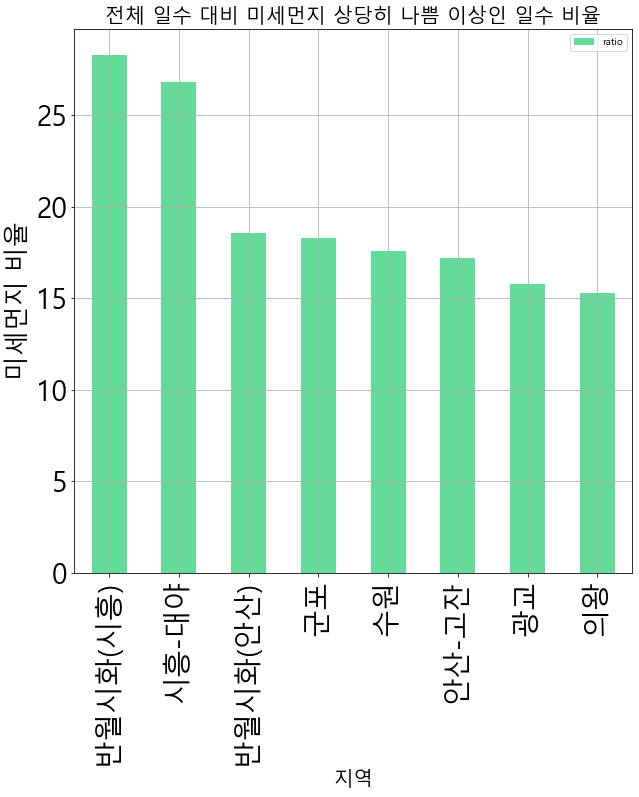

In [38]:
plt.figure(figsize=(23,20))
pm_ratio.plot(kind='bar', x='site',y='ratio',grid=True, figsize=(10,10),color="#64DB99")
plt.title("전체 일수 대비 미세먼지 상당히 나쁨 이상인 일수 비율",size=20)
plt.xlabel('지역',size=20)
plt.ylabel('미세먼지 비율',size=25)
plt.tick_params(labelsize=28)
# plt.savefig(r'D:/pm/plot_ratio.png', format='png')
plt.show()

### 지역, 계절별 미세먼지 상당히 나쁨 이상 COUNT

In [39]:
pm_upper_site= pm[pm['pm25']>=38]
pm_upper_site = pm_upper_site.groupby(['site','season'])['pm25'].count().reset_index(drop=False)

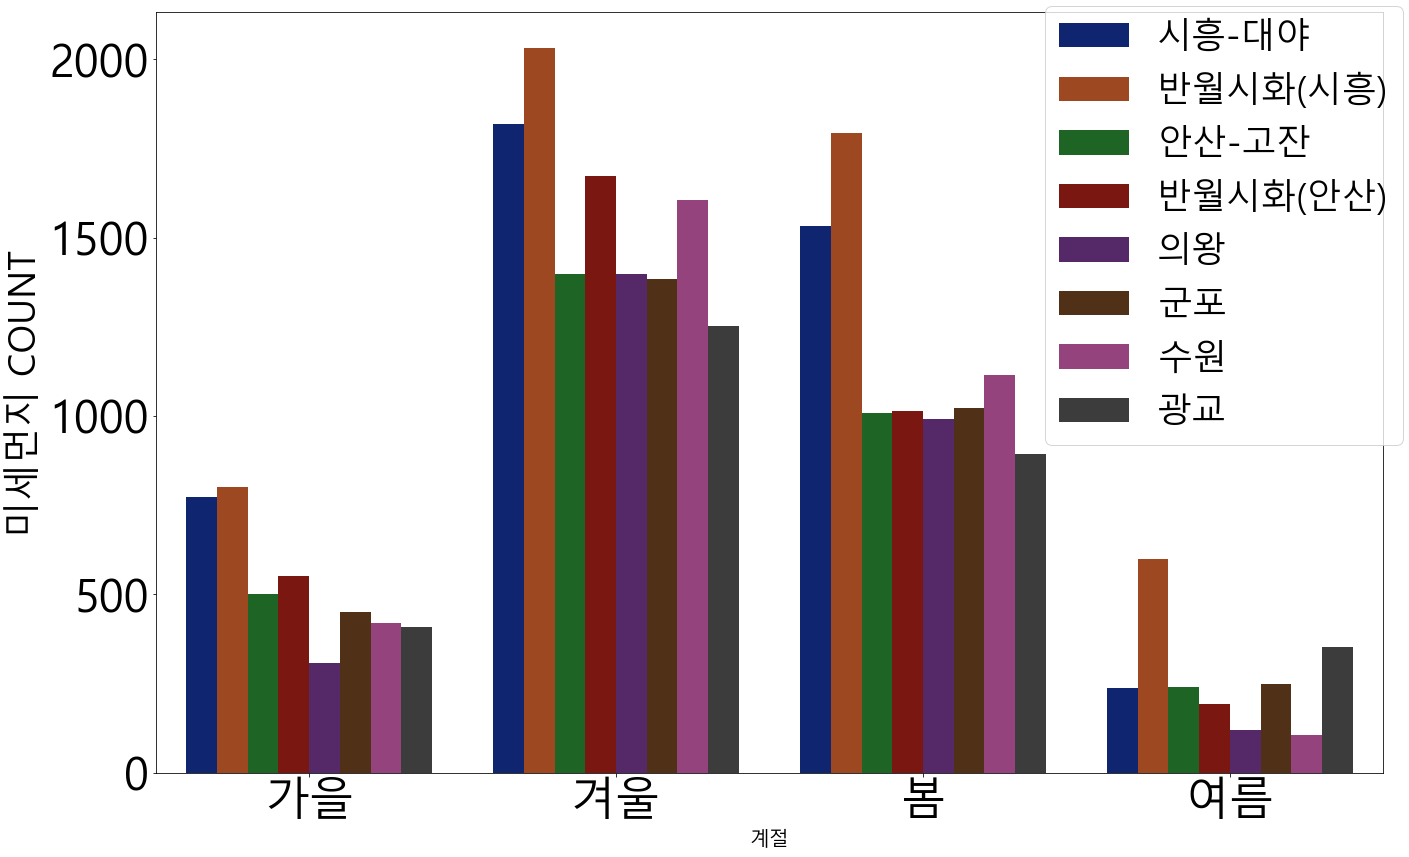

In [40]:
PM_list = ['최고','좋음','양호','보통','나쁨','상당히 나쁨','매우 나쁨','최악']
plt.figure(figsize=(22,14))
sns.barplot(x="season",y="pm25", hue="site",palette='dark',hue_order=site_list ,data=pm_upper_site)
plt.xlabel('계절',size=20)
plt.ylabel('미세먼지 COUNT',size=37)
plt.tick_params(labelsize=45)
plt.legend(fontsize=35,bbox_to_anchor=(1.03, 1.03))
# plt.savefig(r'D:/pm/season_count.png', format='png')
plt.show()


### 월별 미세먼지 상당히 나쁨 이상 일수

In [41]:
pm_upper_month= pm[pm['pm25']>=38]
pm_upper_month = pm_upper_month.groupby(['site','month','season'])['pm25'].count().reset_index(drop=False)
season_list= pm_upper_month['season'].unique().tolist()

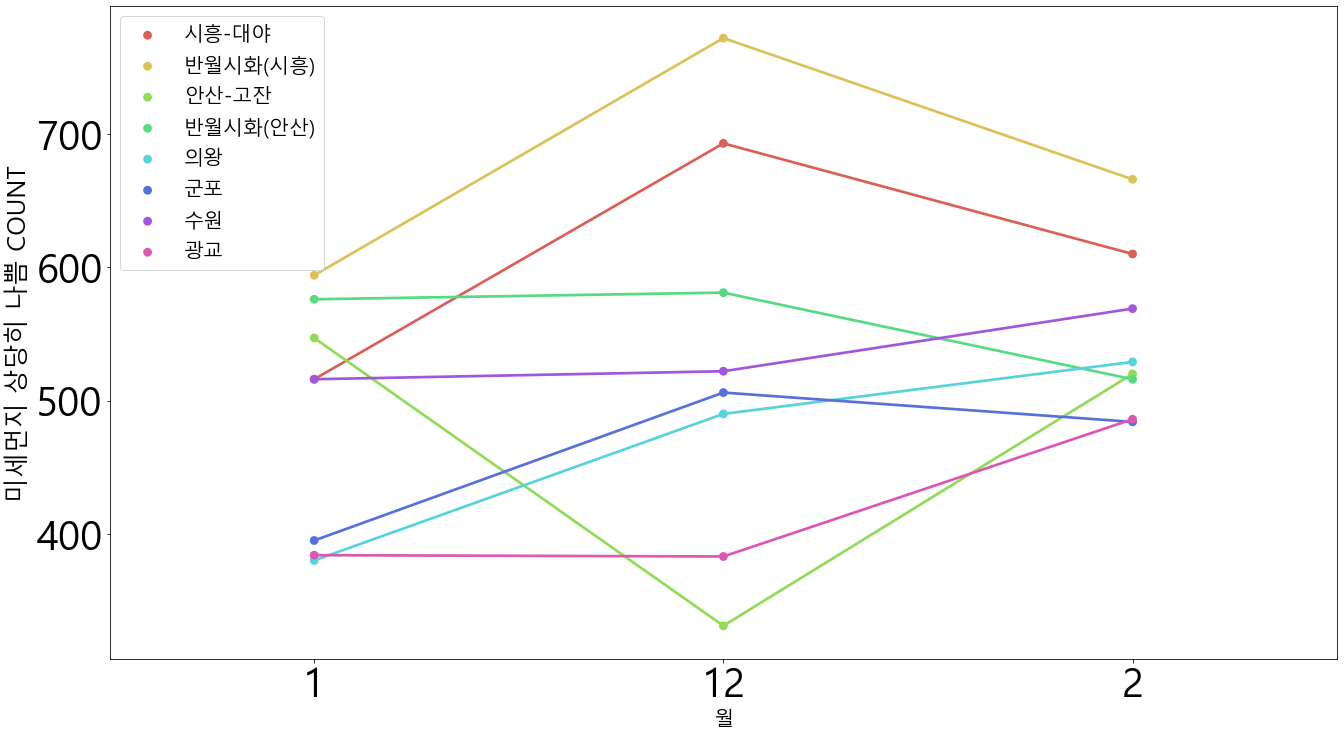

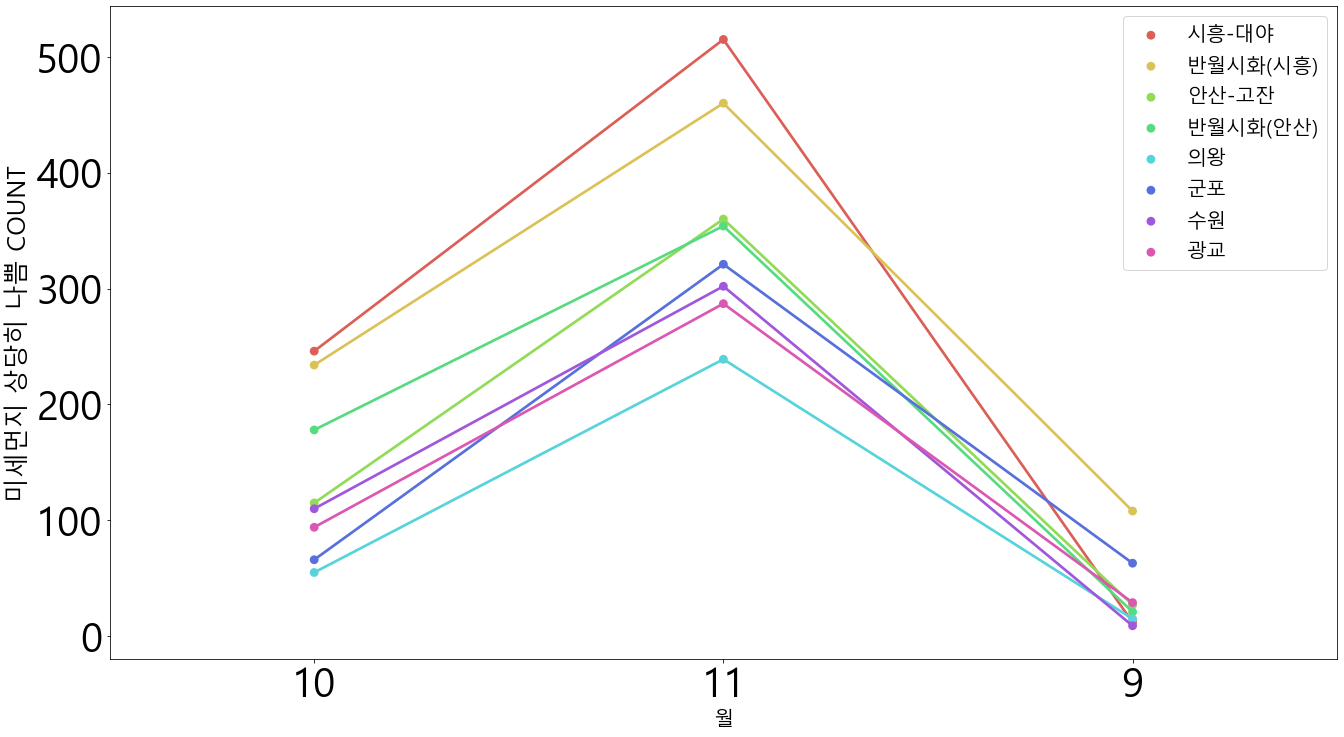

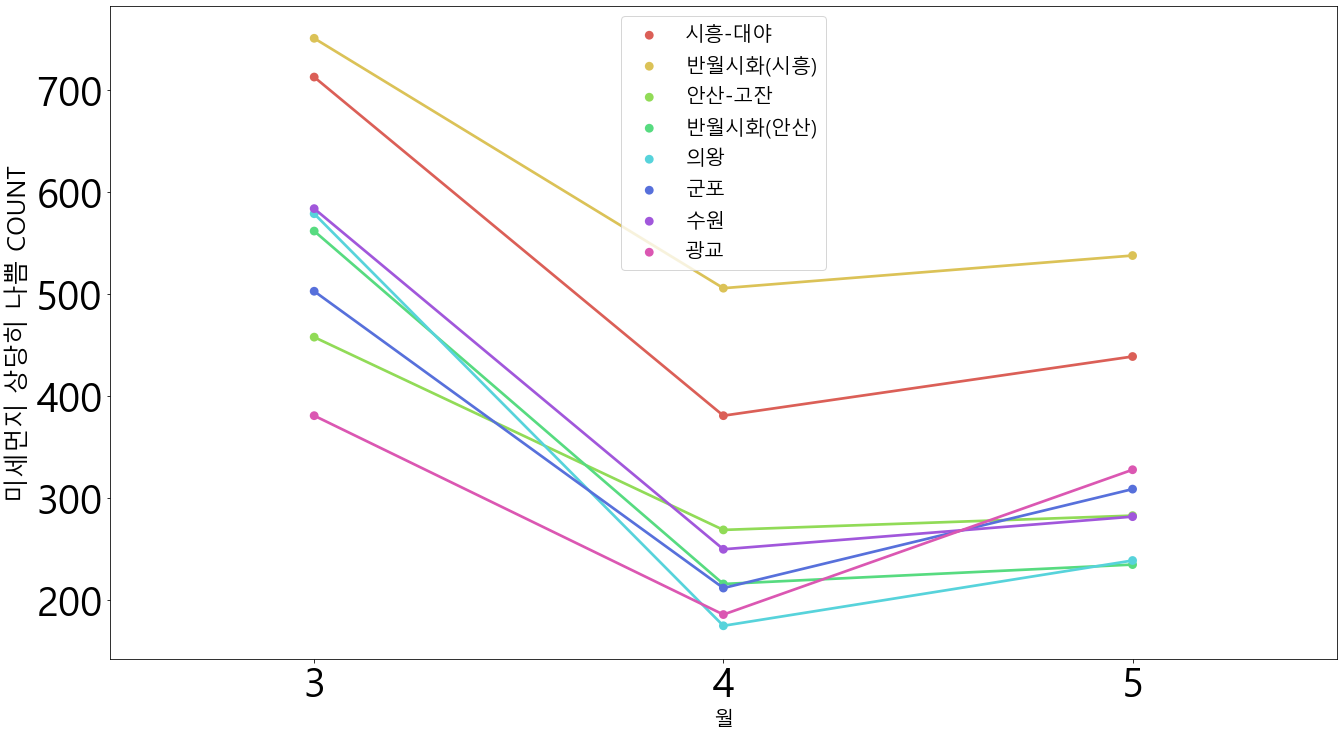

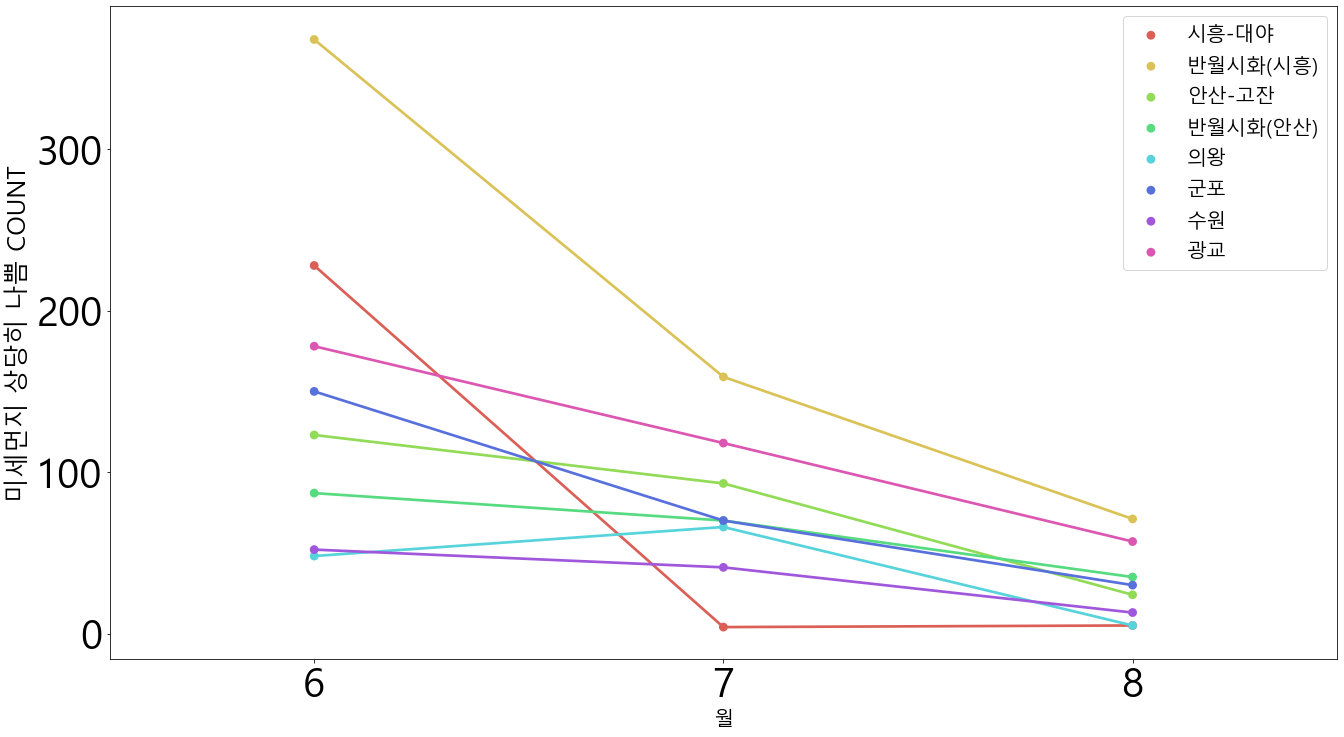

In [42]:
for i in season_list:
    data = pm_upper_month[pm_upper_month['season']==i]
    plt.figure(figsize=(22,12))
    sns.pointplot(x='month',y='pm25', hue="site",palette='hls' ,hue_order=site_list,data=data)
    # plt.title("월별 미세먼지 상당히 나쁨",size=25)
    plt.xlabel('월',size=20)
    plt.ylabel('미세먼지 상당히 나쁨 COUNT',size=25)
    plt.tick_params(labelsize=40)
    plt.legend(fontsize=20)
    # plt.savefig(r'D:/pm/month_line.png', format='png')
    plt.show()

### 지역별, 시간대별 평균 미세먼지 농도

In [43]:
pm_time = pm.groupby(['site','time'])['pm25'].mean().reset_index(drop=False)

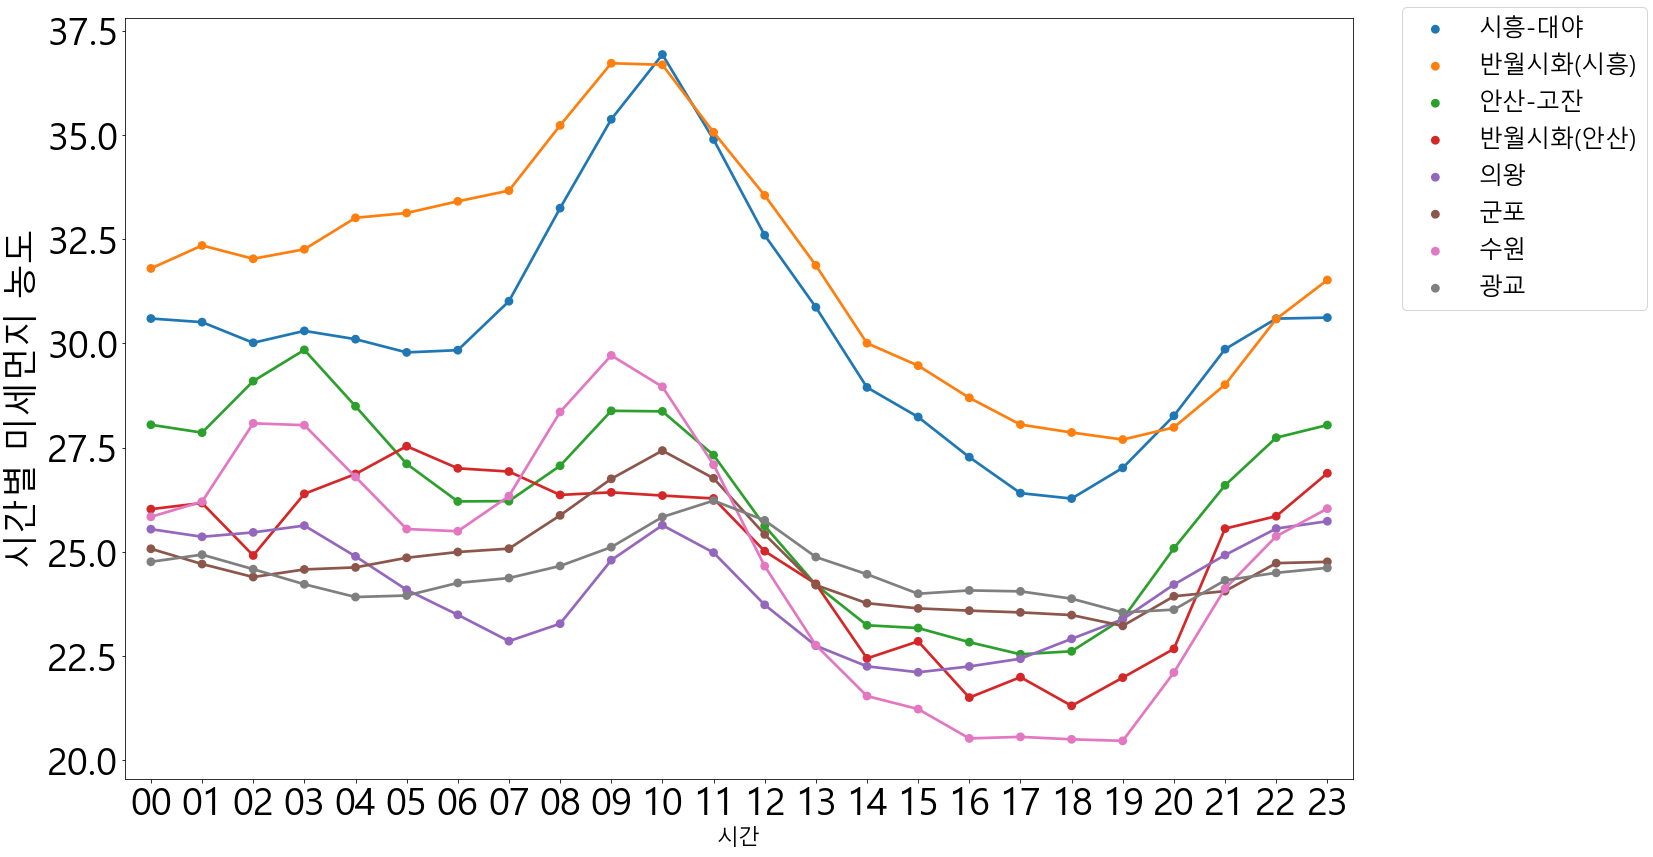

In [44]:
plt.figure(figsize=(22,14))
sns.pointplot(data=pm_time, x="time", y="pm25", hue='site',hue_order=site_list)
plt.xlabel('시간',size=22)
plt.ylabel('시간별 미세먼지 농도',size=35)
# plt.title('지역별, 시간대별 평균 미세먼지 농도',size = 25)
plt.tick_params(labelsize=38)
plt.legend(fontsize=24,bbox_to_anchor=(1.03, 1.03))
# plt.savefig(r'D:/pm/time_mean_line.png', format='png')

No handles with labels found to put in legend.


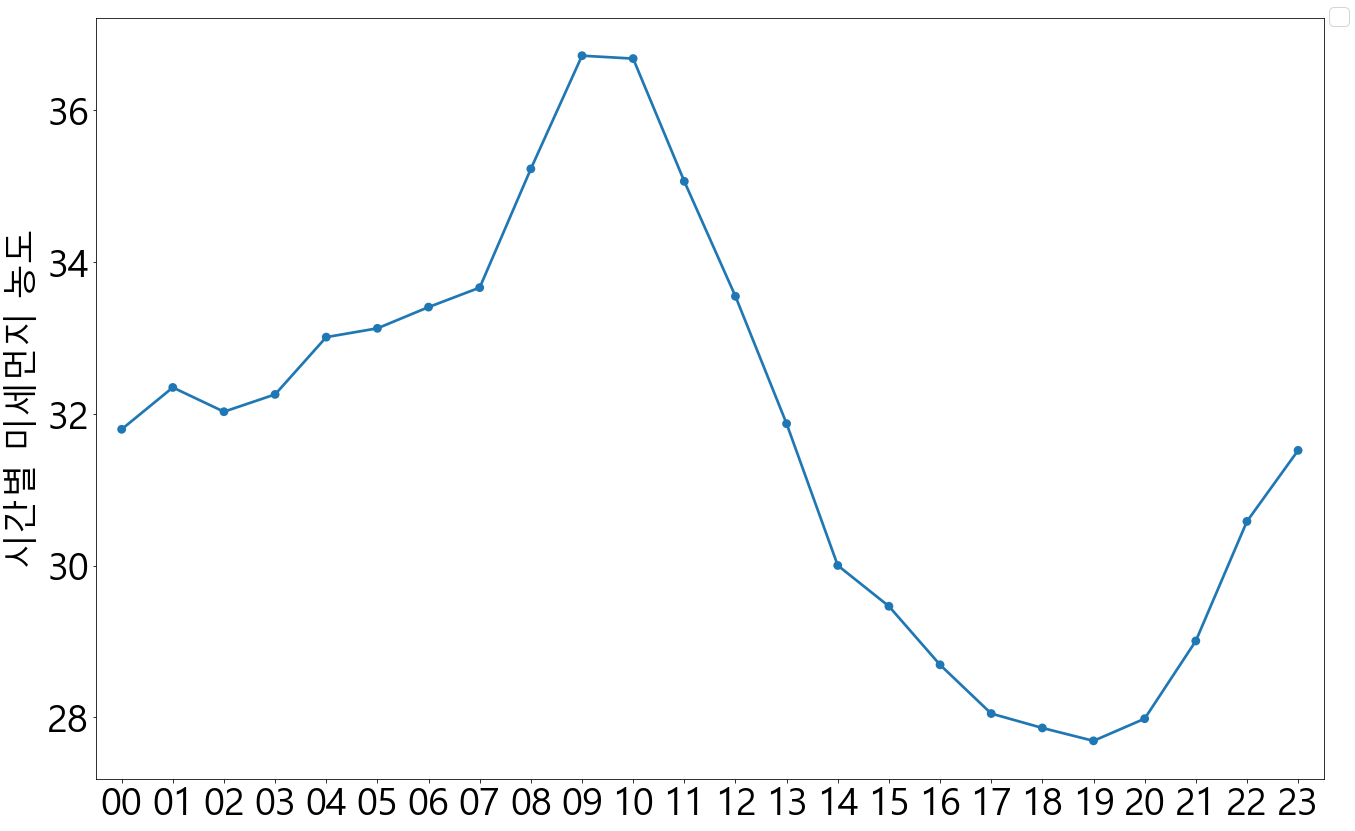

In [45]:
sihwa_time = pm[pm['site']=='반월시화(시흥)']
sihwa_time = sihwa_time.groupby(['time'])['pm25'].mean().reset_index(drop=False)
plt.figure(figsize=(22,14))
sns.pointplot(data=sihwa_time, x="time", y="pm25")
plt.xlabel('',size=22)
plt.ylabel('시간별 미세먼지 농도',size=35)
# plt.title('지역별, 시간대별 평균 미세먼지 농도',size = 25)
plt.tick_params(labelsize=38)
plt.legend(fontsize=24,bbox_to_anchor=(1.03, 1.03))


### 시간별 미세먼지 상당히 나쁨 이상 COUNT

In [46]:
pm_upper_time= pm[pm['pm25']>=38]
pm_upper_time = pm_upper_time.groupby(['site','time'])['pm25'].count().reset_index(drop=False)

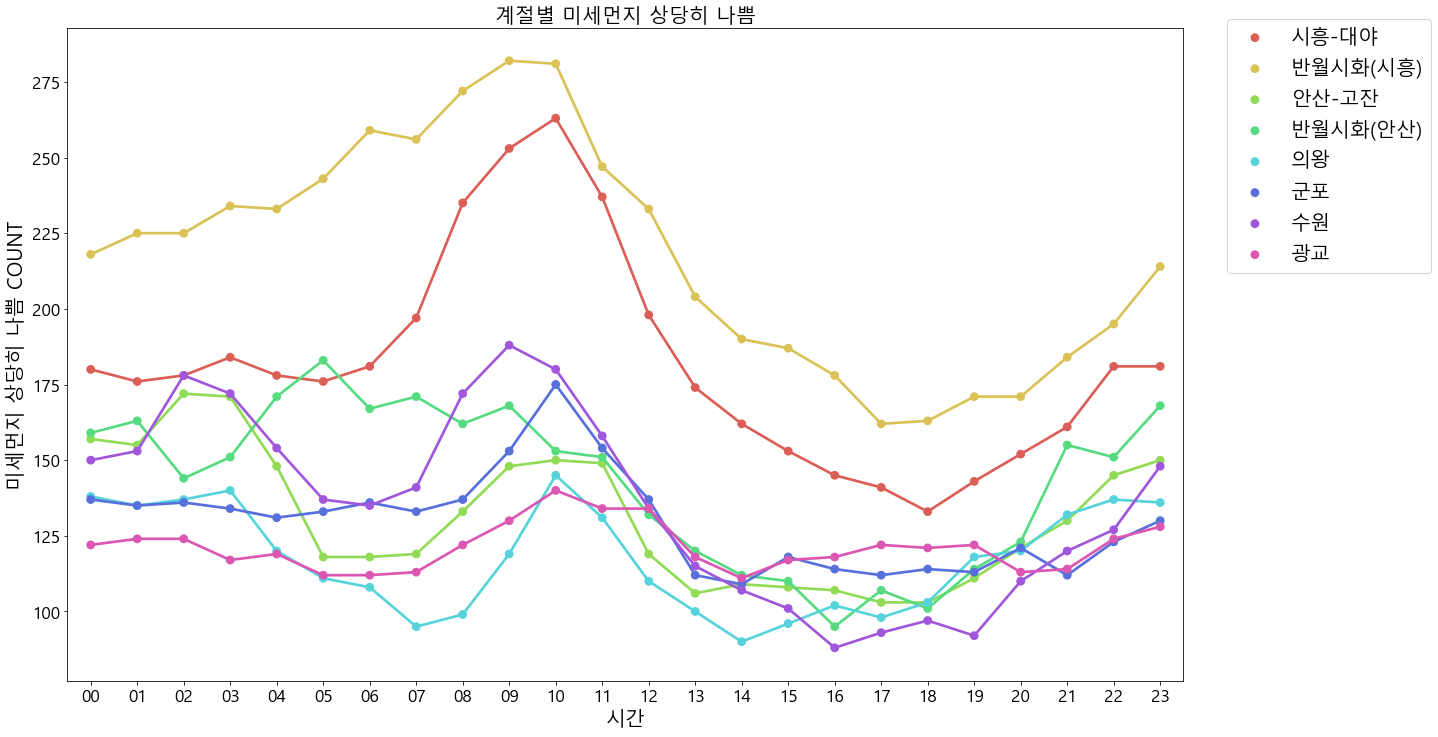

In [47]:
plt.figure(figsize=(20,12))
sns.pointplot(x="time",y='pm25', hue="site",hue_order=site_list,palette='hls' ,data=pm_upper_time)
plt.title("계절별 미세먼지 상당히 나쁨",size=20)
plt.xlabel('시간',size=20)
plt.ylabel('미세먼지 상당히 나쁨 COUNT',size=20)
plt.tick_params(labelsize=17)
plt.legend(fontsize=20,bbox_to_anchor=(1.03, 1.03))
plt.show()

### 변수별 HISTOGRAM 

지역별로 진행하고 첨도 확인

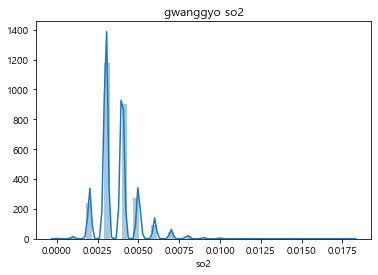

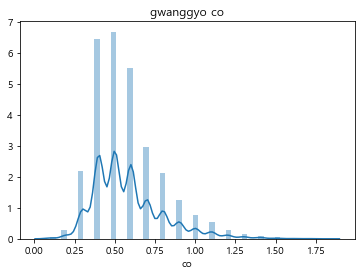

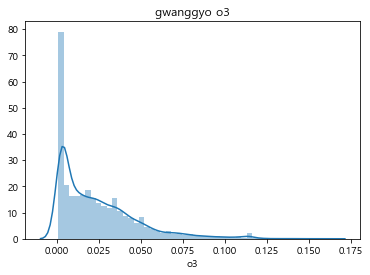

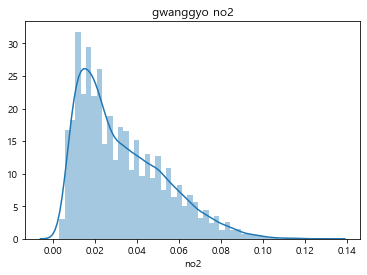

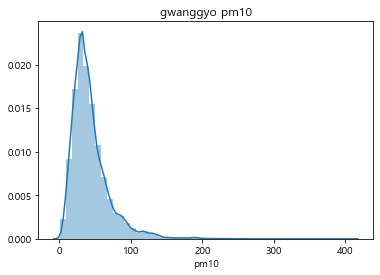

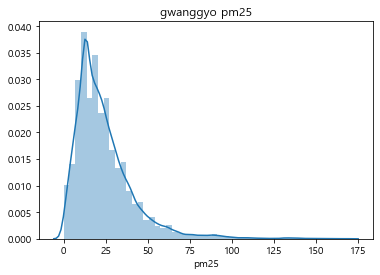

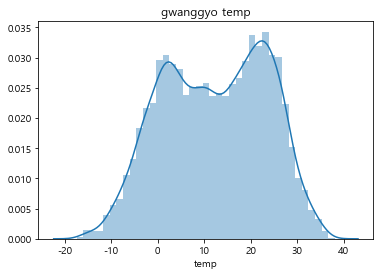

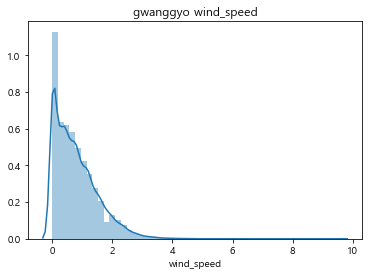

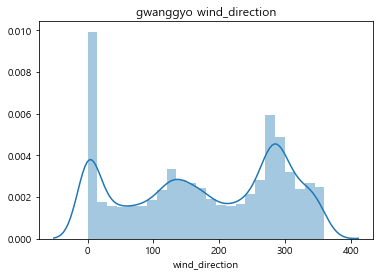

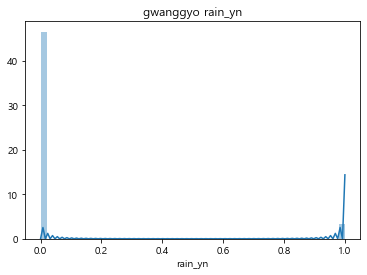

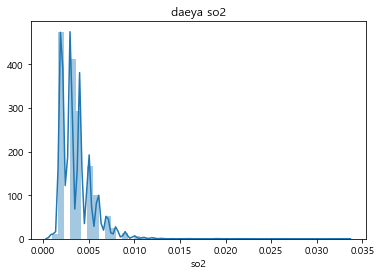

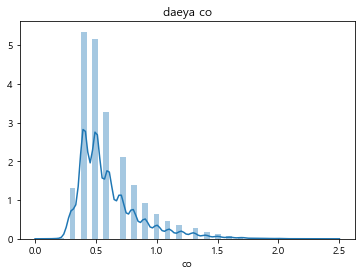

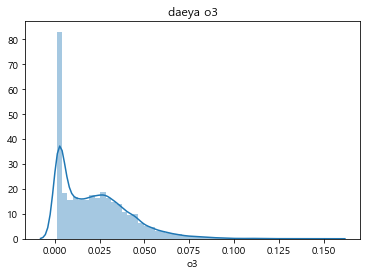

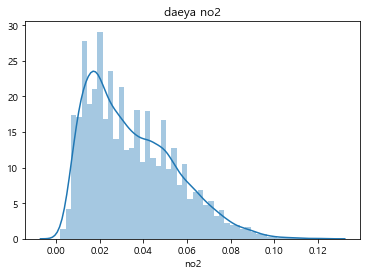

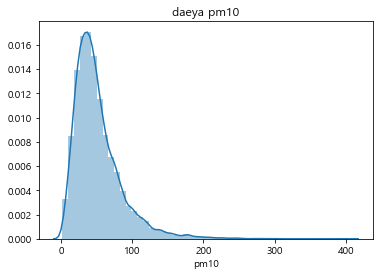

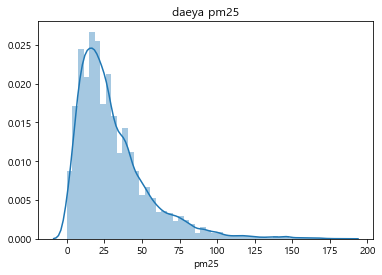

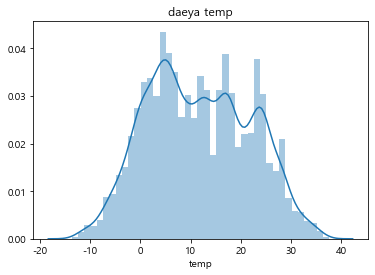

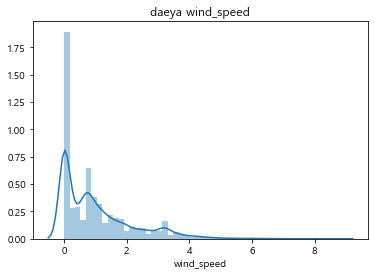

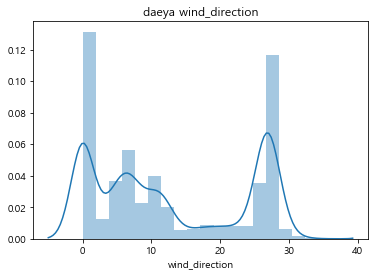

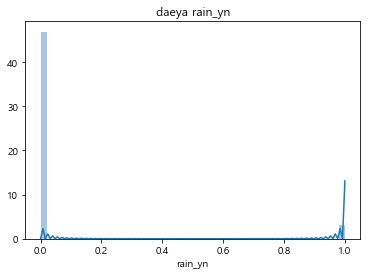

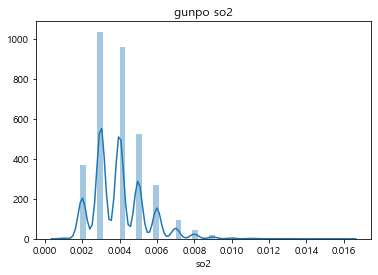

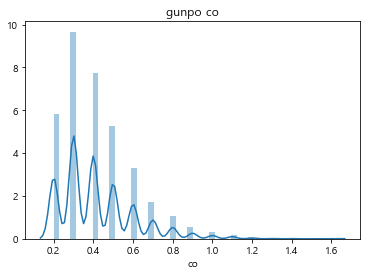

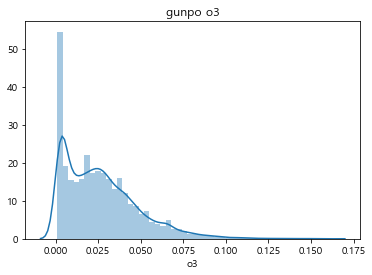

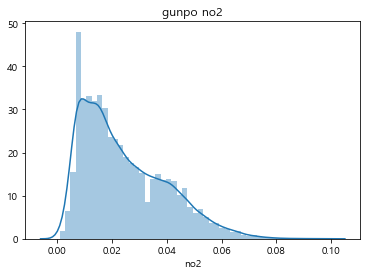

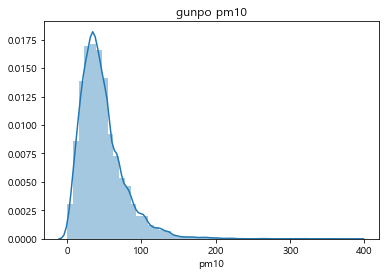

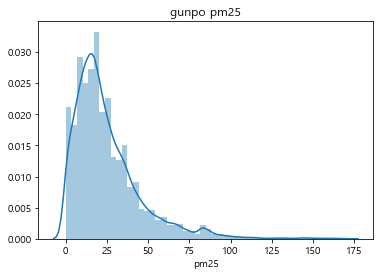

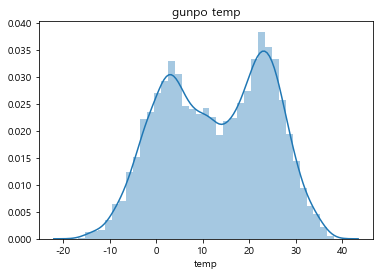

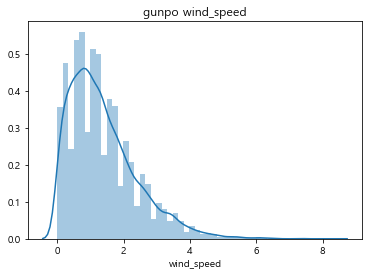

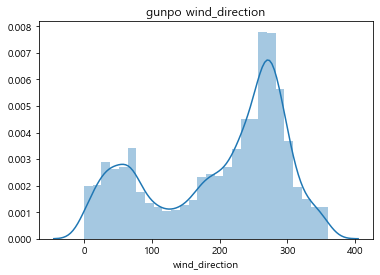

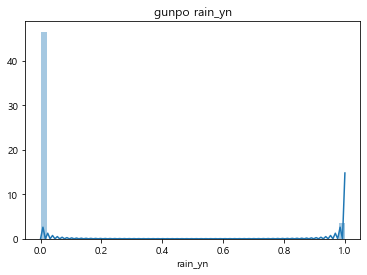

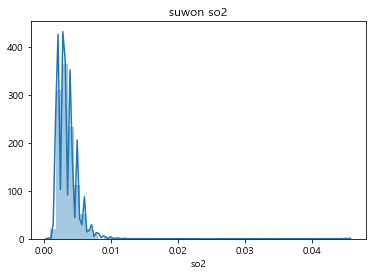

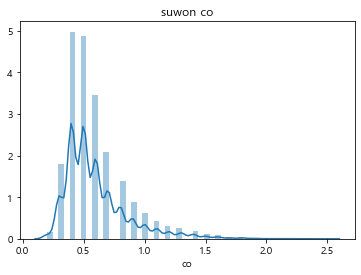

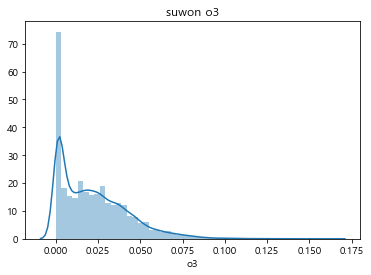

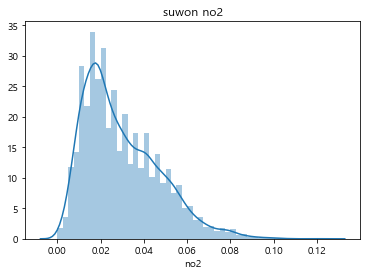

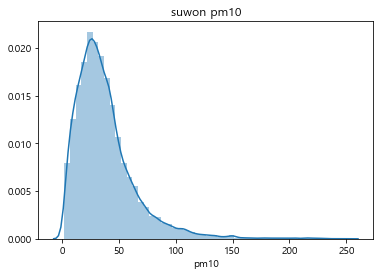

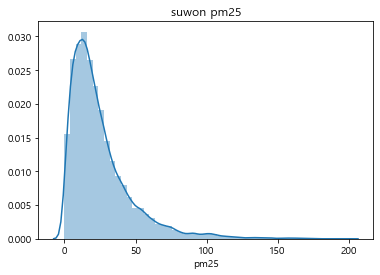

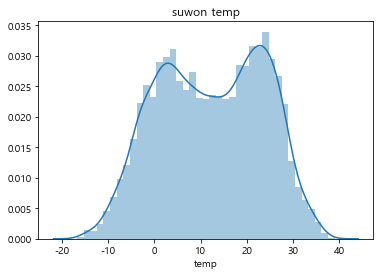

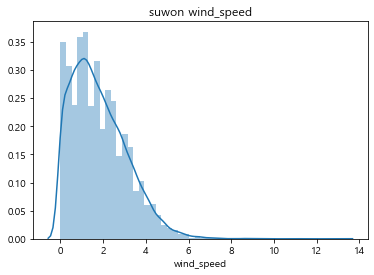

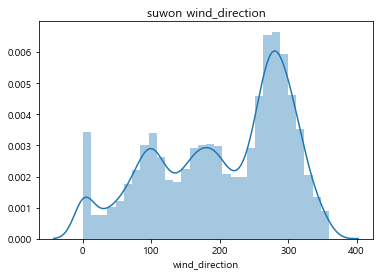

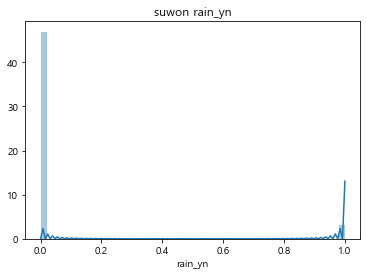

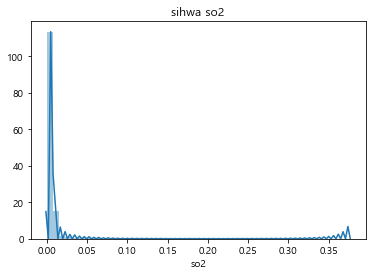

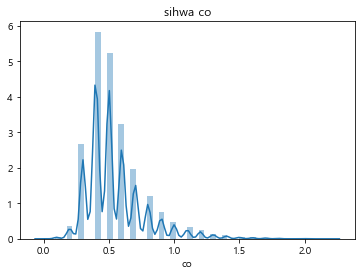

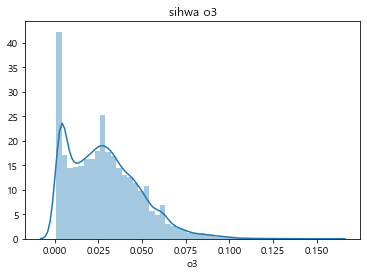

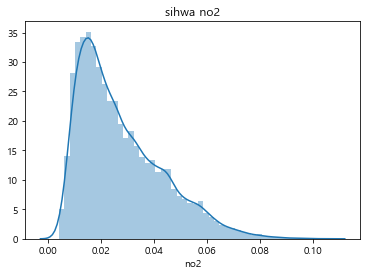

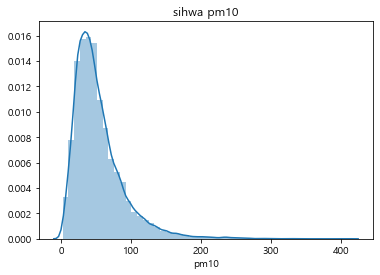

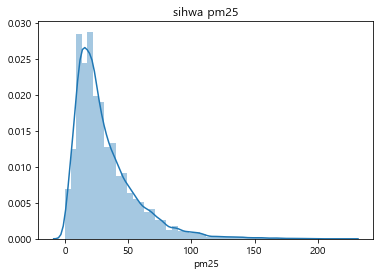

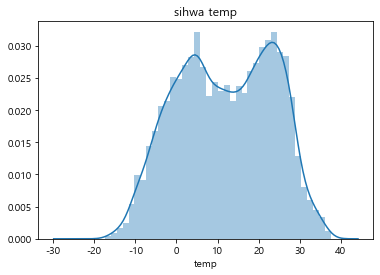

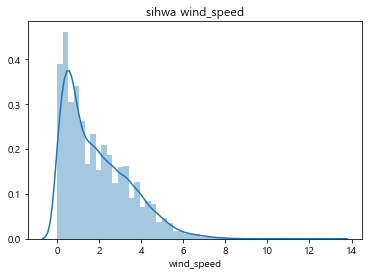

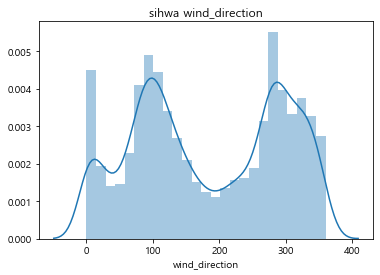

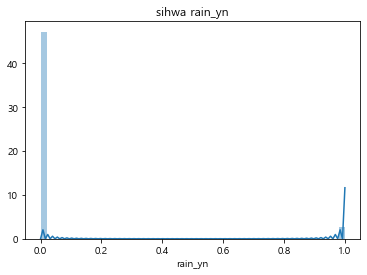

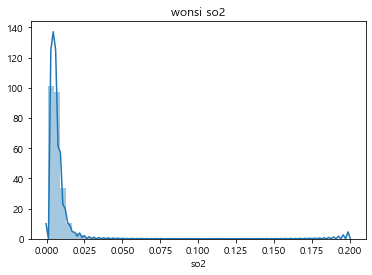

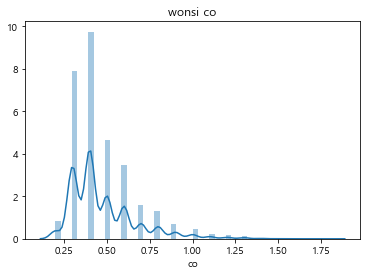

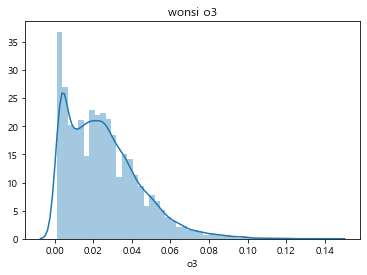

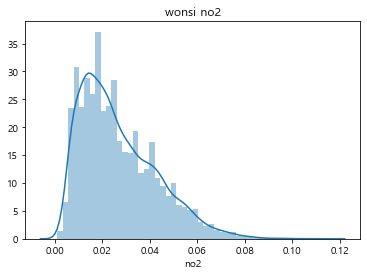

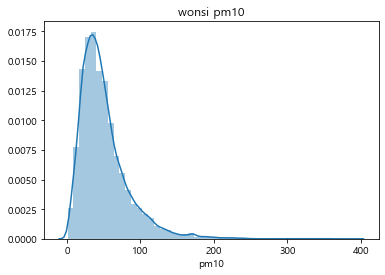

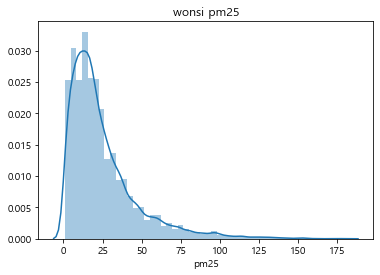

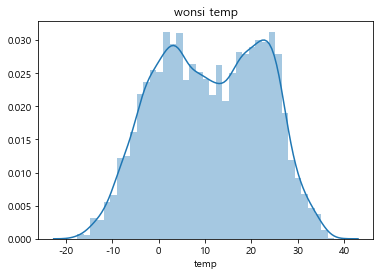

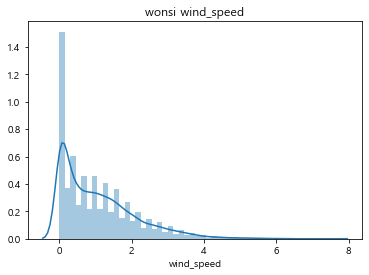

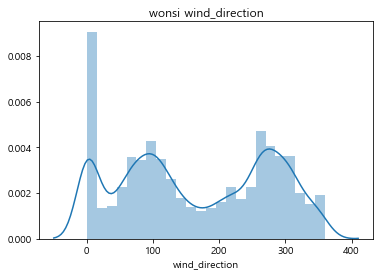

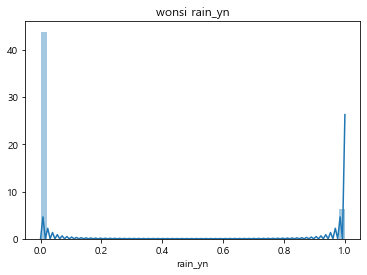

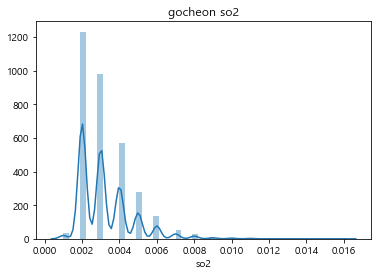

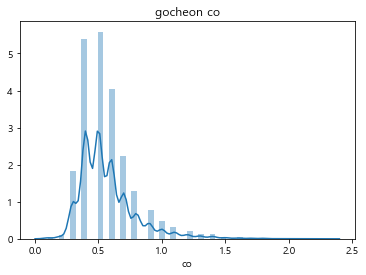

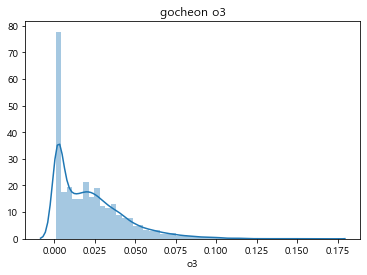

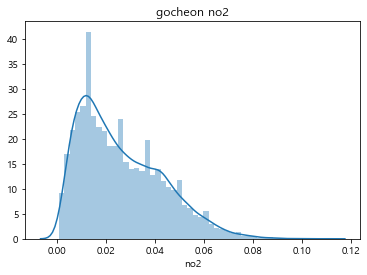

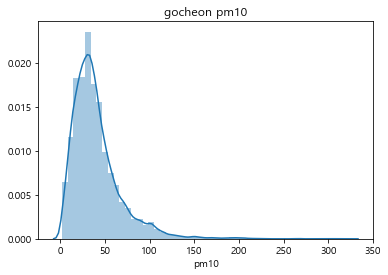

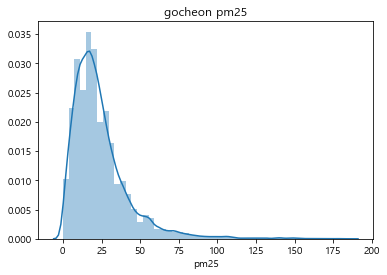

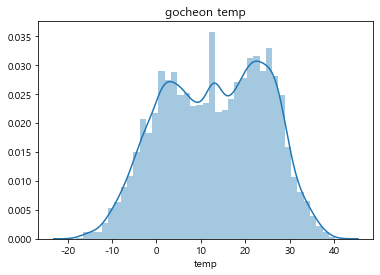

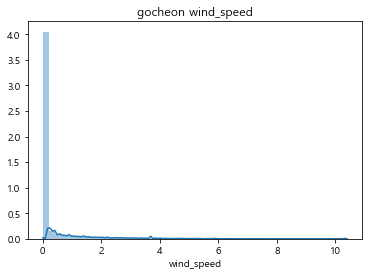

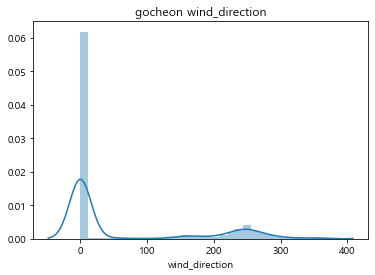

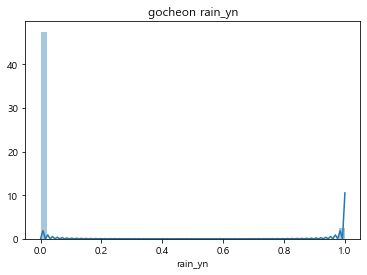

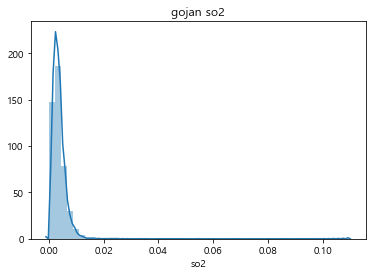

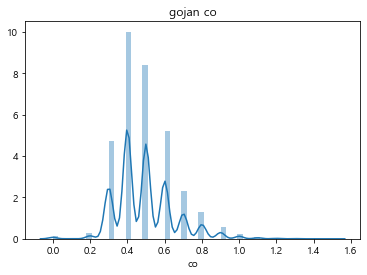

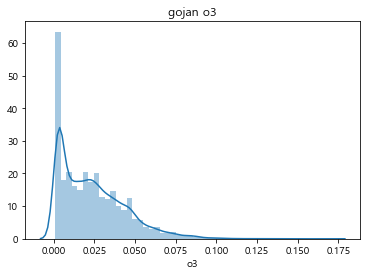

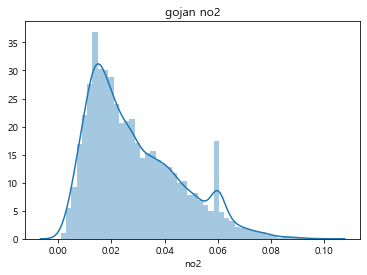

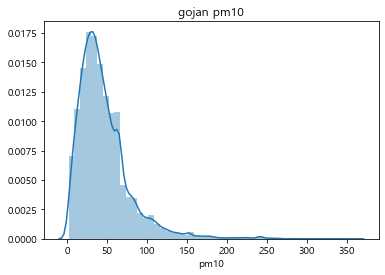

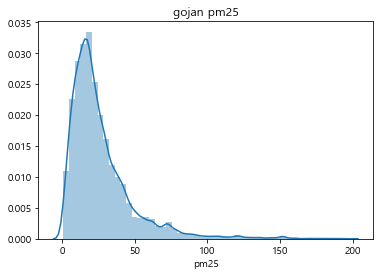

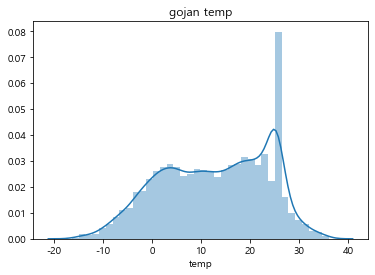

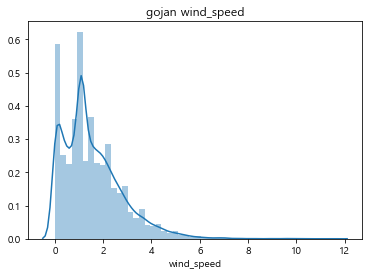

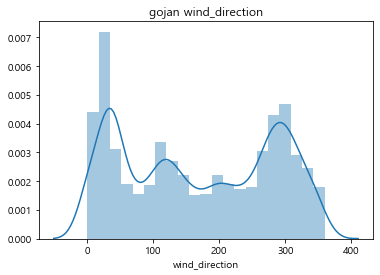

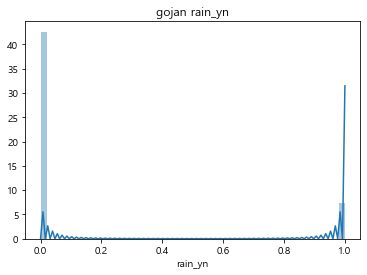

In [48]:
column_site = ['gwanggyo','daeya','gunpo' , 'suwon', 'sihwa','wonsi','gocheon','gojan']
data_cols = ['so2','co','o3', 'no2','pm10', 'pm25', 'temp', 'wind_speed', 'wind_direction', 'rain_yn']
for site in column_site:
    for cols in data_cols:
        plt.figsize=(20,15)
        sns.distplot(globals()[site][cols])
        plt.title(f'{site} {cols}')
        plt.show()

### Heatmap 상관관계

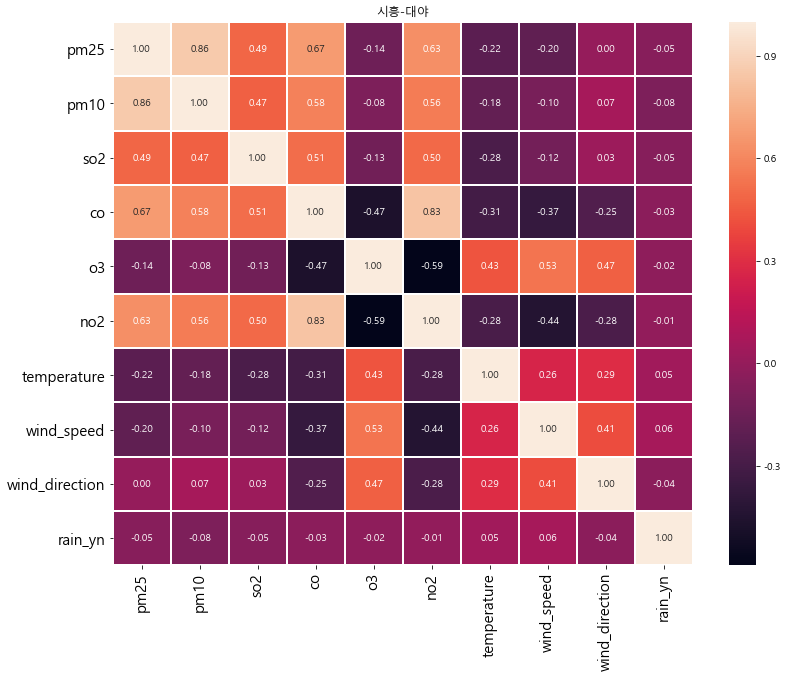

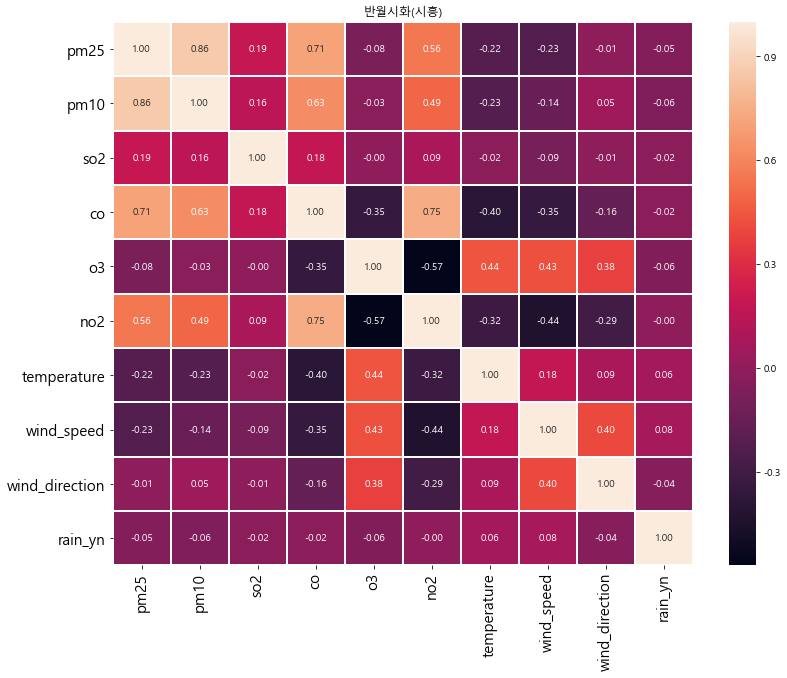

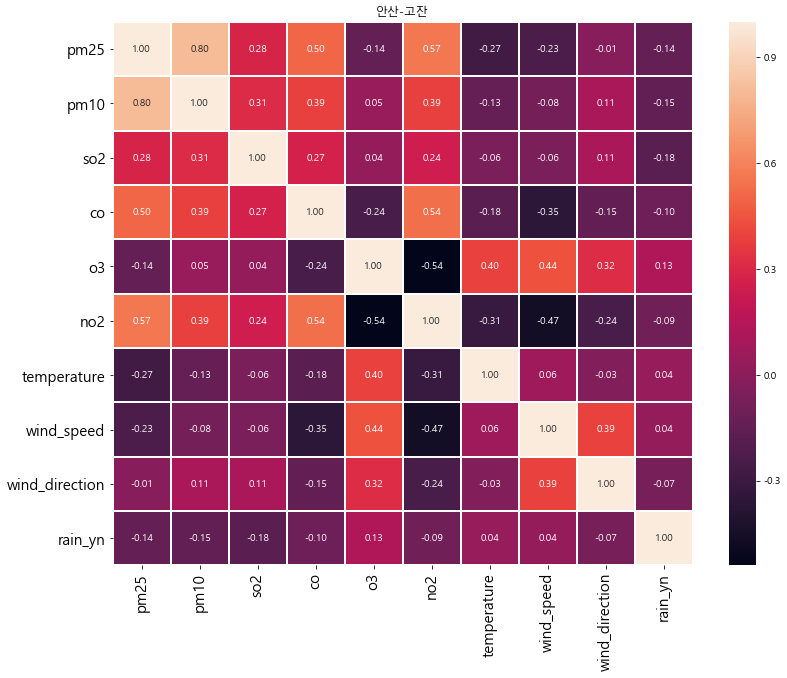

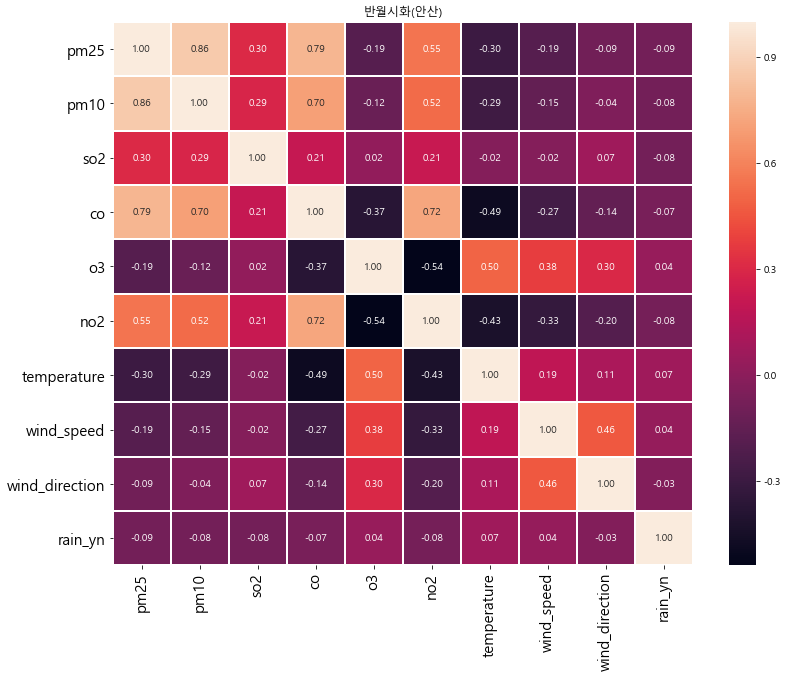

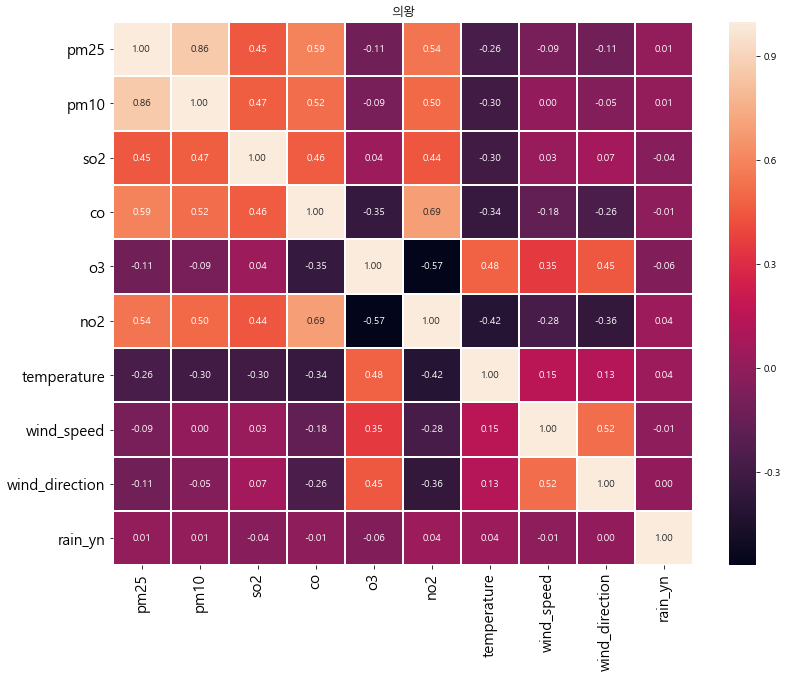

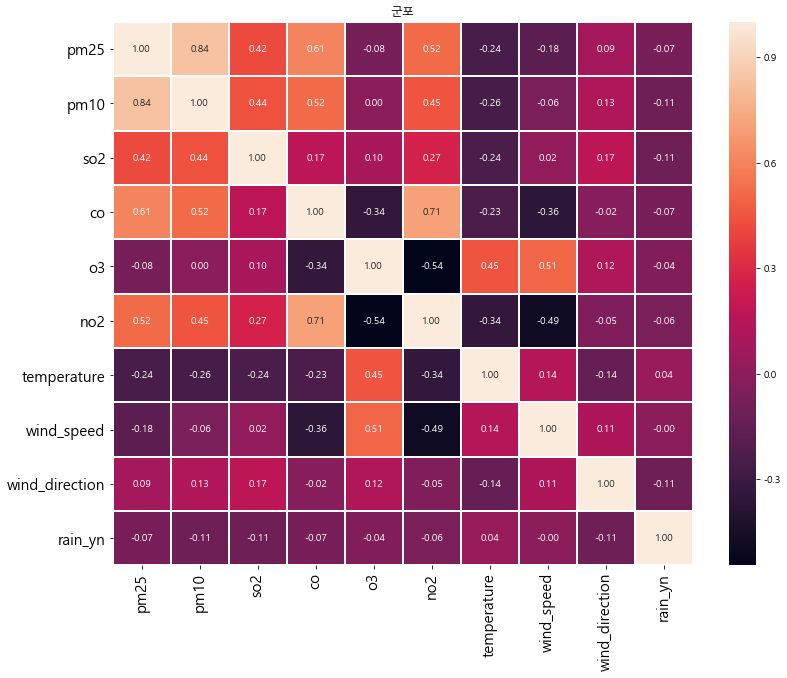

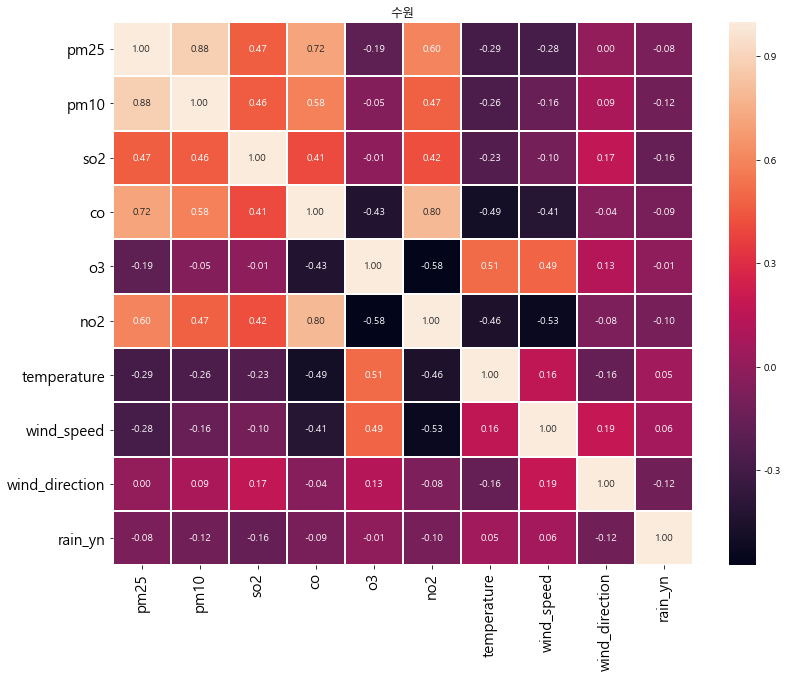

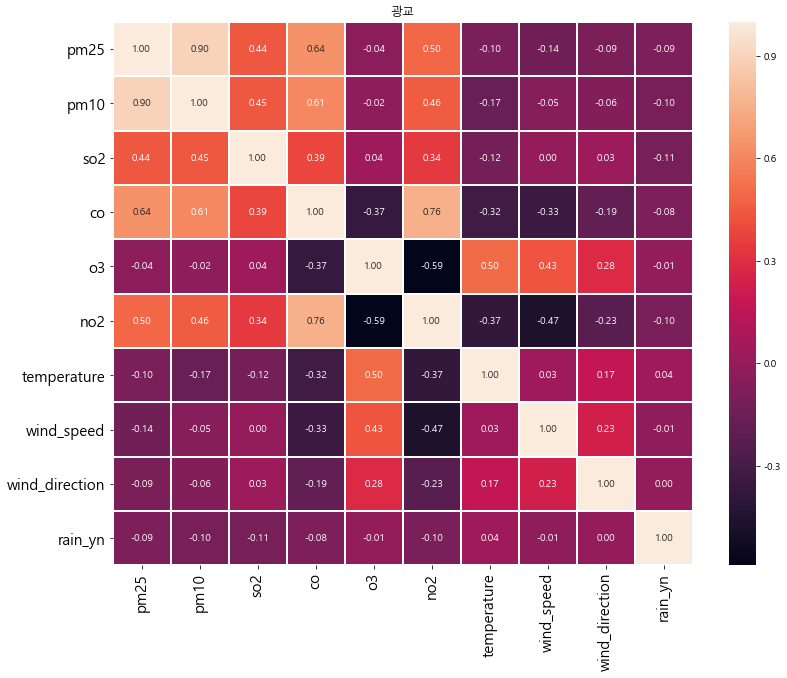

In [49]:
pm_heatmap = pm_del.copy()
pm_heatmap.drop(['date'],axis=1,inplace=True)
pm_heatmap.rename(columns = {'temp':'temperature'},inplace=True)

for site in site_list:
    plt.figure(figsize=(13,10))
    heatmap_data = pm_heatmap[pm_heatmap['site']==f'{site}']
    heatmap_data.drop('site',axis=1,inplace=True)
    heatmap_data =heatmap_data[['pm25','pm10', 'so2', 'co', 'o3', 'no2', 'temperature','wind_speed', 'wind_direction', 'rain_yn']]
    sns.heatmap(data = heatmap_data.corr(), annot=True,  linewidths=1, fmt = '.2f')
    plt.tick_params(labelsize=15)
    plt.title(f'{site}')
    plt.show()

### 지역별 rain_yn 변수 COUNTPLOT

rain_yn이 강수 유무에 따라 0, 10이다. 0,1로 변경하고 Categorical 변수로 변경하여 진행해야 됨

다른지역보다 대야, 시화산단, 원시, 고색동의 강수유무 데이터가 적음(확인 필요함)

In [50]:
pm_rain = pm_del.copy()
pm_rain.head()

date      site   co    no2     o3    so2  pm10  pm25  temp  \
0 2017-12-01        광교  0.3  0.017  0.034  0.003  10.0   2.0  -4.1   
2 2017-12-01     시흥-대야  0.4  0.016  0.027  0.004  20.0   5.0  -2.5   
3 2017-12-01        군포  0.3  0.012  0.026  0.004  13.0  12.0  -3.6   
5 2017-12-01        수원  0.5  0.023  0.022  0.004  10.0  15.0  -3.8   
7 2017-12-01  반월시화(시흥)  0.4  0.017  0.030  0.005  21.0  13.0  -4.6   

   wind_direction  wind_speed  rain_yn  humid         ymd month time     md  \
0            81.1         1.5      0.0    NaN  2017-12-01    12   00  12-01   
2             3.6         0.5      0.0    NaN  2017-12-01    12   00  12-01   
3           291.1         1.7      0.0    NaN  2017-12-01    12   00  12-01   
5           335.3         2.9      0.0   39.0  2017-12-01    12   00  12-01   
7             4.5         1.9      0.0   43.6  2017-12-01    12   00  12-01   

  weekday season PM_categorical  
0  Friday     겨울             최고  
2  Friday     겨울             최고  
3  Friday     겨울             좋음  
5  Friday     겨울             좋음  
7  Friday     겨울             좋음

In [51]:
pm_rain = pm_rain[['site','rain_yn']]
pm_rain.dropna(inplace=True)

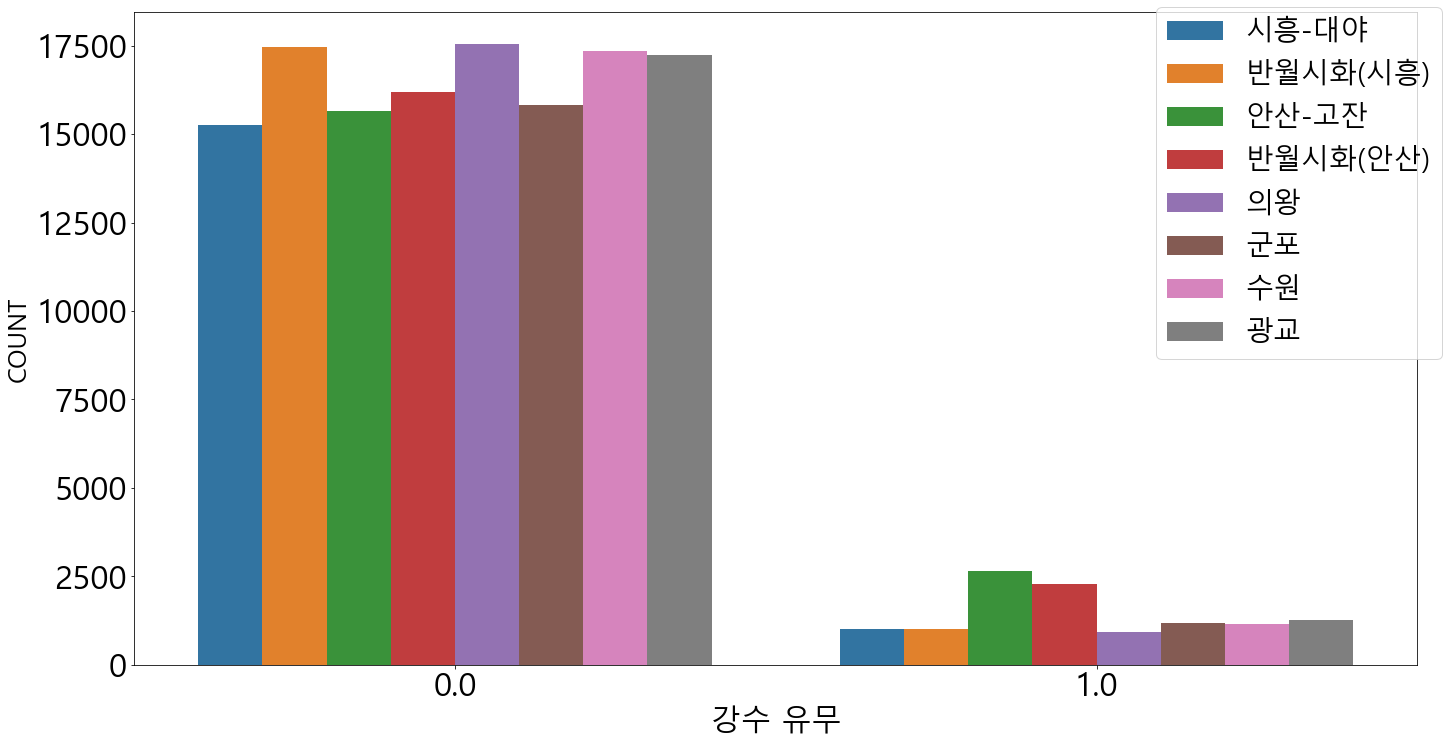

In [52]:
plt.figure(figsize=(23,12))
sns.countplot(x="rain_yn", hue='site', hue_order=site_list,data=pm_rain)
plt.tick_params(labelsize=33)
# plt.title(" 미세먼지 8단계 분류 COUNT",size=25)
plt.xlabel('강수 유무',size=30)
plt.ylabel('COUNT',size=25)
plt.legend(fontsize=28,bbox_to_anchor=(1.03, 1.03))
# plt.savefig(r'D:/pm/plot_count.png', format='png')

In [53]:
rain_list = pm_rain['site'].unique().tolist()
for list in rain_list:
    print(list,len(pm_rain[pm_rain['site']==list]))

광교 18481
시흥-대야 16273
군포 17017
수원 18481
반월시화(시흥) 18481
반월시화(안산) 18481
의왕 18481
안산-고잔 18318


In [54]:
for site, column in zip(column_site,site_KR):
    globals()[f'{site}'].dropna(inplace=True)

In [55]:
def house_regression(idt,house) :
    house = house[['date','pm25']]
    house.dropna(inplace=True)
    final_r = pd.merge(idt,house ,on ='date')
    final_r.drop('date',axis=1,inplace=True)
    result = sm.ols(formula = 'pm25 ~ idt_so2+idt_co+idt_o3+idt_no2+\
                idt_temp+idt_wind_speed+idt_wind_direction+idt_rain_yn+idt_humid+idt_season', data = final_r).fit()
    print(result.summary())
    
def vif(idt,house):
    house = house[['date','pm25']]
    final_r = pd.merge(idt,house ,on ='date')
    final_r.drop('date',axis=1,inplace=True)
    y, X = dmatrices('pm25 ~ idt_so2+idt_co+idt_o3+idt_no2+\
                idt_temp+idt_wind_speed+idt_wind_direction+idt_rain_yn+idt_humid+idt_season',final_r,return_type = 'dataframe')

    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["features"] = X.columns 
    print(vif)

In [56]:
idt = sihwa.copy()
for i in ["season",'time','rain_yn']:
    idt[i] = pd.get_dummies(idt[i])
idt.drop(['site','ymd','time','month','md','weekday','PM_categorical'], axis=1, inplace=True)
idt.columns = ['date','idt_so2','idt_co','idt_o3','idt_no2','idt_pm10',
           'idt_pm25','idt_temp', 'idt_wind_speed','idt_wind_direction', 'idt_rain_yn','idt_humid','idt_season']
idt.dropna(inplace=True)

In [57]:
regression_list = ['daeya','gojan' , 'wonsi', 'gocheon','gunpo','suwon','gwanggyo']
change_list  = ['시흥-대야','안산-고잔', '반월시화(안산)', '의왕', '군포' , '수원' , '광교']

In [58]:
for i,j in zip(regression_list,change_list):
    house = globals()[f'{i}'].copy()
    print(f'{j}')
    house_regression(idt,house)
    vif(idt,house)

시흥-대야
                            OLS Regression Results                            
Dep. Variable:                   pm25   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.521
Method:                 Least Squares   F-statistic:                     1815.
Date:                Wed, 19 Feb 2020   Prob (F-statistic):               0.00
Time:                        16:52:16   Log-Likelihood:                -70696.
No. Observations:               16698   AIC:                         1.414e+05
Df Residuals:                   16687   BIC:                         1.415e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            -36.0486 

    VIF Factor            features
0    70.147542           Intercept
1     2.695068             idt_so2
2     3.239552              idt_co
3     2.196666              idt_o3
4     1.056929             idt_no2
5     1.553377            idt_temp
6     1.304682      idt_wind_speed
7     1.740079  idt_wind_direction
8     1.047300         idt_rain_yn
9     1.659107           idt_humid
10    1.109102          idt_season
의왕
                            OLS Regression Results                            
Dep. Variable:                   pm25   R-squared:                       0.431
Model:                            OLS   Adj. R-squared:                  0.430
Method:                 Least Squares   F-statistic:                     1429.
Date:                Wed, 19 Feb 2020   Prob (F-statistic):               0.00
Time:                        16:52:16   Log-Likelihood:                -77029.
No. Observations:               18906   AIC:                         1.541e+05
Df Residuals:           

    VIF Factor            features
0    70.147542           Intercept
1     2.695068             idt_so2
2     3.239552              idt_co
3     2.196666              idt_o3
4     1.056929             idt_no2
5     1.553377            idt_temp
6     1.304682      idt_wind_speed
7     1.740079  idt_wind_direction
8     1.047300         idt_rain_yn
9     1.659107           idt_humid
10    1.109102          idt_season
광교
                            OLS Regression Results                            
Dep. Variable:                   pm25   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-statistic:                     1214.
Date:                Wed, 19 Feb 2020   Prob (F-statistic):               0.00
Time:                        16:52:17   Log-Likelihood:                -76724.
No. Observations:               18906   AIC:                         1.535e+05
Df Residuals:           

## 교통량 추가 후 회귀분석

## 교통량

In [59]:
sihwa = df[df['site']=='시화산단']
date_split(sihwa)
sihwa['season'] = sihwa['md'].apply(season)
sihwa.drop(['ymd','time','md','weekday'],axis=1,inplace=True)
car = pd.read_csv("D:/data/car/kokdo_highway.csv",encoding='CP949')
car.drop('site',axis=1,inplace=True)
car['date'] = pd.to_datetime(car['date'], format='%Y-%m-%d %H:%M')
car['date'] = car['date'].astype(str)
sihwa['date'] = sihwa['date'].astype(str)
df_car = pd.merge(sihwa,car, on=['date'])
df_car = df_car.drop_duplicates(subset=['date'], keep='last')
for i in ["season",'rain_yn']:
    df_car[i] = pd.get_dummies(df_car[i])
df_car.head()

date  site   co    no2     o3    so2  pm10  pm25  temp  \
0  2017-12-01 00:00:00  시화산단  0.4  0.017  0.030  0.005  21.0  13.0  -4.6   
1  2017-12-01 01:00:00  시화산단  0.5  0.013  0.032  0.004  25.0  14.0  -6.3   
2  2017-12-01 02:00:00  시화산단  0.5  0.017  0.027  0.005  25.0  13.0  -6.7   
3  2017-12-01 03:00:00  시화산단  0.5  0.015  0.028  0.005  27.0  13.0  -7.2   
4  2017-12-01 04:00:00  시화산단  0.5  0.015  0.028  0.004  20.0  12.0  -7.3   

   wind_direction  wind_speed  rain_yn  humid month  season  highway  \
0             4.5         1.9        1   43.6    12       0   2221.0   
1             NaN         NaN        1   55.5    12       0   1622.0   
2            58.6         0.6        1   60.9    12       0   1312.0   
3            11.3         0.7        1   66.5    12       0   1501.0   
4           325.4         0.7        1   57.1    12       0   2597.0   

   normal_road  
0          635  
1          375  
2          217  
3          153  
4          141

In [60]:
idt, house = df_car.drop(['pm25'], axis=1) , df_car[['date','pm25']]
final_r = pd.merge(idt,house ,on ='date')
final_r = final_r.drop_duplicates(subset=['date'], keep='last')
final_r.drop('date',axis=1,inplace=True)
result = sm.ols(formula = 'pm25 ~ so2+co+o3+no2+temp+wind_speed+highway+normal_road+\
                wind_direction+rain_yn+season', data = final_r).fit()
print(result.summary())


y, X = dmatrices('pm25 ~ so2+co+o3+no2+temp+wind_speed+wind_direction+highway+normal_road+\
                 rain_yn+season',final_r,return_type = 'dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns 
print(vif)

                            OLS Regression Results                            
Dep. Variable:                   pm25   R-squared:                       0.562
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     937.3
Date:                Wed, 19 Feb 2020   Prob (F-statistic):               0.00
Time:                        16:52:17   Log-Likelihood:                -33150.
No. Observations:                8032   AIC:                         6.632e+04
Df Residuals:                    8020   BIC:                         6.641e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -19.9968      1.219    -16.

## speed

In [61]:
# load data
df = pd.read_csv('D:/data/row_final.csv')
speed = pd.read_csv('D:/data/speed.csv')
df.head()

co                 date    no2     o3  pm10  pm25 site    so2  humid  \
0  0.3  2017-12-01 00:00:00  0.017  0.034  10.0   2.0  광교동  0.003    NaN   
1  0.4  2017-12-01 00:00:00  0.011  0.018  30.0   4.0  중2동  0.003    NaN   
2  0.4  2017-12-01 00:00:00  0.016  0.027  20.0   5.0  대야동  0.004    NaN   
3  0.3  2017-12-01 00:00:00  0.012  0.026  13.0  12.0  산본동  0.004    NaN   
4  0.5  2017-12-01 00:00:00  0.025  0.021  18.0  10.0  철산동  0.002    NaN   

   rain_yn  temp  wind_direction  wind_speed  
0      0.0  -4.1            81.1         1.5  
1      0.0  -3.6            12.8         0.7  
2      0.0  -2.5             3.6         0.5  
3      0.0  -3.6           291.1         1.7  
4      0.0  -3.7           340.0         1.7

In [62]:
def date_split(df) :
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M')
    df['ymd'] = [d.date() for d in df['date']]
    df['time'] = [d.time() for d in df['date']]
    df['time'] = df['time'].apply(lambda x: x.strftime('%H'))
    df['md'] = df['ymd'].apply(lambda x: x.strftime('%m-%d'))
    df['weekday'] =df['date'].apply(lambda x: x.strftime('%A'))
def season(x):
    if '05-31'>= x>='03-01':
        return('Spring')
    elif '08-31' >=x >= '06-01':
        return('Summer')
    elif '11-30' >= x >= '09-01':
        return('Fall')
    else: return('Winter')

def speed_categori(x):
    if 15>=x:
        return('Smooth')
    elif 25>=x>=15:
        return('Normal')
    else: return('Congestion')

In [63]:
df = df[['site', 'date', 'so2', 'co', 'o3', 'no2', 'pm10', 'pm25', 'temp',
       'wind_speed', 'wind_direction', 'rain_yn', 'humid']]
df = df.iloc[:, [0,1,2,3,4,5,6,7,8,9,10,11,12]]
df.loc[df['temp'] <= -30, 'temp' ] = np.float("nan")
df['rain_yn'] = df['rain_yn'].apply(lambda x: x if x==0 else 1)
df['wind_8_direction'] = pd.cut(df.wind_direction, 
                                                   bins=[0,22.5,67.5,112.5,157.5,202.5,247.5,292.5,337.5],
                                                   labels=["북","북동", "동", "남동","남","남서","서","북서"])
df['wind_8_direction'].fillna("북",inplace=True)
df = df[df['site']=='시화산단']
df.isnull().sum()
date_split(df)
# df = df.dropna()
df['season'] = df['md'].apply(season)
df = df[df['date']>='2017-11-01']
df.drop(['site','md','ymd'],axis=1,inplace=True)
df['date'] = df['date'].astype(str)
df.head()

date    so2   co     o3    no2  pm10  pm25  temp  \
7   2017-12-01 00:00:00  0.005  0.4  0.030  0.017  21.0  13.0  -4.6   
20  2017-12-01 01:00:00  0.004  0.5  0.032  0.013  25.0  14.0  -6.3   
28  2017-12-01 02:00:00  0.005  0.5  0.027  0.017  25.0  13.0  -6.7   
36  2017-12-01 03:00:00  0.005  0.5  0.028  0.015  27.0  13.0  -7.2   
48  2017-12-01 04:00:00  0.004  0.5  0.028  0.015  20.0  12.0  -7.3   

    wind_speed  wind_direction  rain_yn  humid wind_8_direction time weekday  \
7          1.9             4.5      0.0   43.6                북   00  Friday   
20         NaN             NaN      0.0   55.5                북   01  Friday   
28         0.6            58.6      0.0   60.9               북동   02  Friday   
36         0.7            11.3      0.0   66.5                북   03  Friday   
48         0.7           325.4      0.0   57.1               북서   04  Friday   

    season  
7   Winter  
20  Winter  
28  Winter  
36  Winter  
48  Winter

In [64]:
df_bfill = df.fillna(method='bfill')
df_speed = pd.merge(df_bfill,speed,on='date')
df_speed['traffic'] = df_speed['speed'].apply(speed_categori)
df_speed.isnull().sum()

date                0
so2                 0
co                  0
o3                  0
no2                 0
pm10                0
pm25                0
temp                0
wind_speed          0
wind_direction      0
rain_yn             0
humid               0
wind_8_direction    0
time                0
weekday             0
season              0
speed               0
traffic             0
dtype: int64

In [65]:
data_cols = ['so2','co','o3', 'no2','pm10', 'temp','wind_direction', 'wind_speed', 'humid']
min_max_scaler = MinMaxScaler()
df_minmax = df_speed[data_cols]
df_other = df_speed[['date','pm25','season','time','rain_yn','traffic']]
for i in ["season",'time','rain_yn','traffic']:
    df_other[i] = pd.get_dummies(df_other[i])
min_max_scaler.fit(df_minmax)
speed_scale = min_max_scaler.transform(df_minmax)
speed_scale = pd.DataFrame(speed_scale, columns=data_cols, index=df_minmax.index.values)
for i in data_cols :
    speed_scale[i] = speed_scale[i].shift(4)
#     df_other['pm25_window'] = df_other['pm25'].shift(4)
    df_other['pm25_window_moving'] = df_other['pm25'].rolling(window=4).mean()

In [66]:
speed_scale = pd.concat([speed_scale,df_other],axis=1)
speed_scale.dropna(inplace=True)

In [67]:
data = speed_scale.copy()
result = sm.ols(formula = 'pm25 ~ so2+co+o3+no2+temp+wind_speed+\
                wind_direction+rain_yn+season+pm25_window_moving+humid+traffic', data = data).fit()
print(result.summary())

y, X = dmatrices('pm25 ~so2+co+o3+no2+temp+wind_speed+\
                wind_direction+rain_yn+season+pm25_window_moving+humid+traffic',data,return_type = 'dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns 
print(vif)

                            OLS Regression Results                            
Dep. Variable:                   pm25   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                 1.663e+04
Date:                Wed, 19 Feb 2020   Prob (F-statistic):               0.00
Time:                        16:52:18   Log-Likelihood:                -52672.
No. Observations:               15913   AIC:                         1.054e+05
Df Residuals:                   15900   BIC:                         1.055e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              5.4194      0

In [68]:
speed_scale.columns.tolist()

['so2',
 'co',
 'o3',
 'no2',
 'pm10',
 'temp',
 'wind_direction',
 'wind_speed',
 'humid',
 'date',
 'pm25',
 'season',
 'time',
 'rain_yn',
 'traffic',
 'pm25_window_moving']

In [69]:
speed_list  = ['date','so2', 'co', 'o3', 'no2', 'pm10', 'temp', 'wind_direction', 
               'wind_speed', 'humid','pm25_window_moving','pm25']
speed_scale = speed_scale[speed_list]
speed_scale.rename(columns = {'temp':'temperature'},inplace=True)

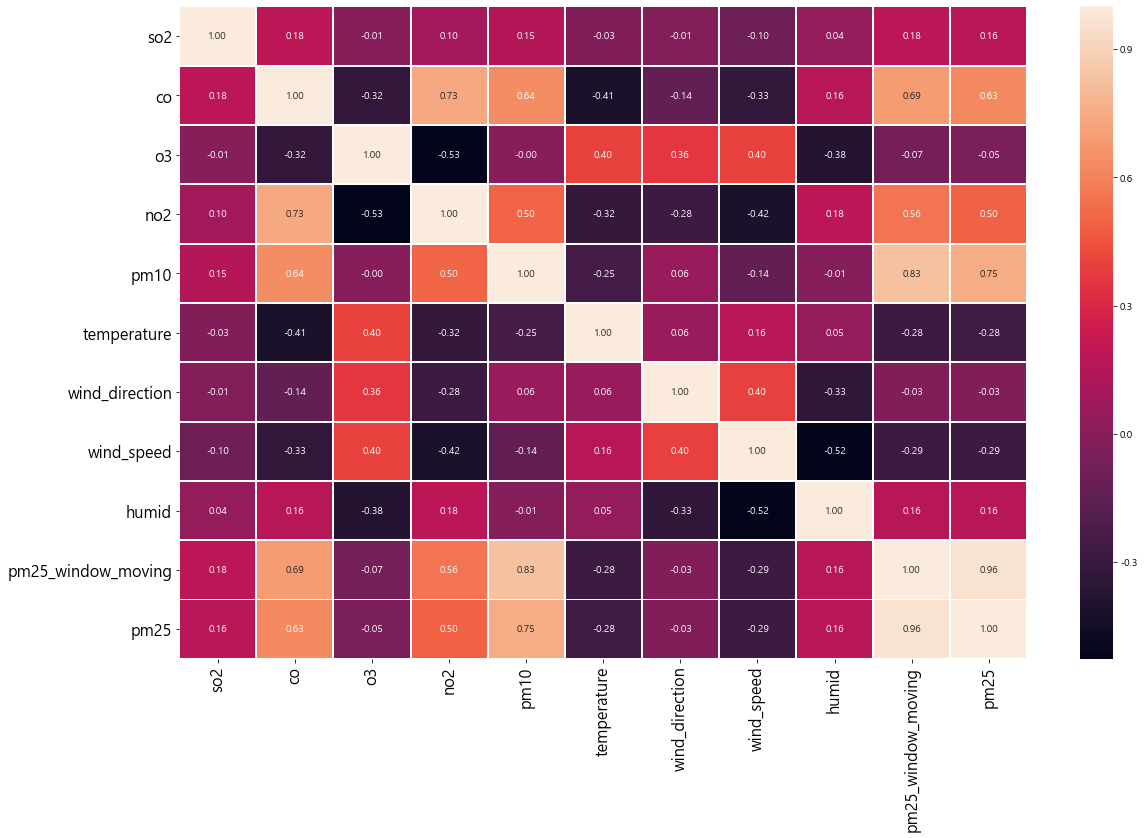

In [70]:
plt.figure(figsize=(19,12))
sns.heatmap(data = speed_scale.corr(), annot=True,  linewidths=1, fmt = '.2f')
plt.tick_params(labelsize=16)
plt.xticks(rotation=90)
plt.show()

# 한달 단위 지역별 차량 등록 대수 EDA

## Preprocessing

차량 등록 데이터의 지역과 미세먼지 데이터의 지역 명칭이 다름

해당 지역을 통일하고 추가 전처리를 진행하여 EDA 진행

In [75]:
# load pm data
df = pd.read_csv('D:/data/row_final.csv',encoding='UTF-8')
df = df[['site', 'date', 'so2', 'co', 'o3', 'no2', 'pm10', 'pm25', 'temp',
       'wind_speed', 'wind_direction', 'rain_yn']]
df = df.iloc[:, [0,1,2,3,4,5,6,7,8,9,10,11]]
df.loc[df['temp'] <= -30, 'temp' ] = np.float("nan")
df = df.dropna()
df['ym'] = df['date'].str[:7]

In [76]:
# car data
car = pd.read_csv('D:/data/car/car_total.csv', encoding='CP949')
car.drop('Unnamed: 0', axis=1, inplace=True)
car.columns = ['date','site','freight_total','special_total']
car['date']  = car['date'].astype(str)
car['ym'] = car['date'].str[:7]
car['month'] = car['ym'].str[5:7]
car['freight_total'] = car['freight_total'].astype(float)
car['car_total'] = car['freight_total']+car['special_total']
car.head()

date   site  freight_total  special_total       ym month  car_total
0  2019-08-19     광명        13559.0            235  2019-08    08    13794.0
1  2019-08-19     군포        13259.0            459  2019-08    08    13718.0
2  2019-08-19     부천        41845.0            795  2019-08    08    42640.0
3  2019-08-19  수원 권선        21366.0            596  2019-08    08    21962.0
4  2019-08-19  수원 영통         8764.0            245  2019-08    08     9009.0

In [77]:
df['site'].unique().tolist()

['광교동', '중2동', '대야동', '산본동', '철산동', '고색동', '시화산단', '원시동', '고천동', '운서', '고잔동']

In [78]:
car['site'].unique().tolist()

['광명', '군포', '부천', '수원 권선', '수원 영통', '시흥', '안산 단원', '안산 상록', '의왕', '동']

In [79]:
car['site'] = car['site'].replace('수원 권선', '고색동')
car['site'] = car['site'].replace('안산 단원', '원시동')
car['site'] = car['site'].replace('수원 영통', '광교동')
car['site'] = car['site'].replace('시흥', '시화산단')
car['site'] = car['site'].replace('안산 상록', '고잔동')
car['site'] = car['site'].replace('의왕', '고천동')
car['site'] = car['site'].replace('군포', '산본동')
car['site'] = car['site'].replace('광명', '철산동')
car['site'] = car['site'].replace('부천', '중2동')
car['site'] = car['site'].replace('동', '운서')

In [80]:
## EDA 위한 파생변수 ymd, md, month, season ,weekday, pm categori 추가
def date_split(df) :
    df['ym'] = df['ym'].astype(str)
    df['month'] = df['ym'].str[5:7]

def season(x):
    if np.isin(x,['03','04','05']):
        return('봄')
    elif np.isin(x,['06','07','08']):
        return('여름')
    elif np.isin(x,['09','10','11']):
        return('가을')
    else: return('겨울')

#### EDA에 사용되는 장소, 날짜, 계절, 등록 대수 변수만 포함

In [81]:
car=car.copy()
car = car[['site','ym','freight_total','special_total']]
car['freight_total'] = car['freight_total'].astype(float)
date_split(car)
car = car.dropna()
car['season'] = car['month'].apply(season)
car['car_total'] = car['freight_total']+car['special_total']

In [82]:
car.head()

site       ym  freight_total  special_total month season  car_total
0  철산동  2019-08        13559.0            235    08     여름    13794.0
1  산본동  2019-08        13259.0            459    08     여름    13718.0
2  중2동  2019-08        41845.0            795    08     여름    42640.0
3  고색동  2019-08        21366.0            596    08     여름    21962.0
4  광교동  2019-08         8764.0            245    08     여름     9009.0

# Exploratory Data Analysis

차량 등록 대수 데이터를 탐색하여 활용 여부 결정

기존 논문에서 미세먼지에 영향을 미친다고 나와있는 화물, 특수화물 차량 대수만 포함

데이터의 변화가 거의 없고, 인천은 구 단위, 경기도는 시 단위거나, 구 단위로 구분되어 활용이 힘들다고 판단함

In [83]:
# pallette ['husl','dark','hls','pastel','bright','Paired']

In [84]:
#order 
site_list = ['운서','철산동','중2동','시화산단','원시동','고잔동','고천동','산본동' ,'고색동','광교동']

In [85]:
car_month = car[car['ym']=='2019-05']
car_month.head()

site       ym  freight_total  special_total month season  car_total
36  철산동  2019-05        13585.0            230    05      봄    13815.0
37  산본동  2019-05        13197.0            461    05      봄    13658.0
38  중2동  2019-05        41897.0            783    05      봄    42680.0
39  고색동  2019-05        21214.0            561    05      봄    21775.0
40  광교동  2019-05         8689.0            240    05      봄     8929.0

Text(0, 0.5, '차량 등록 대수')

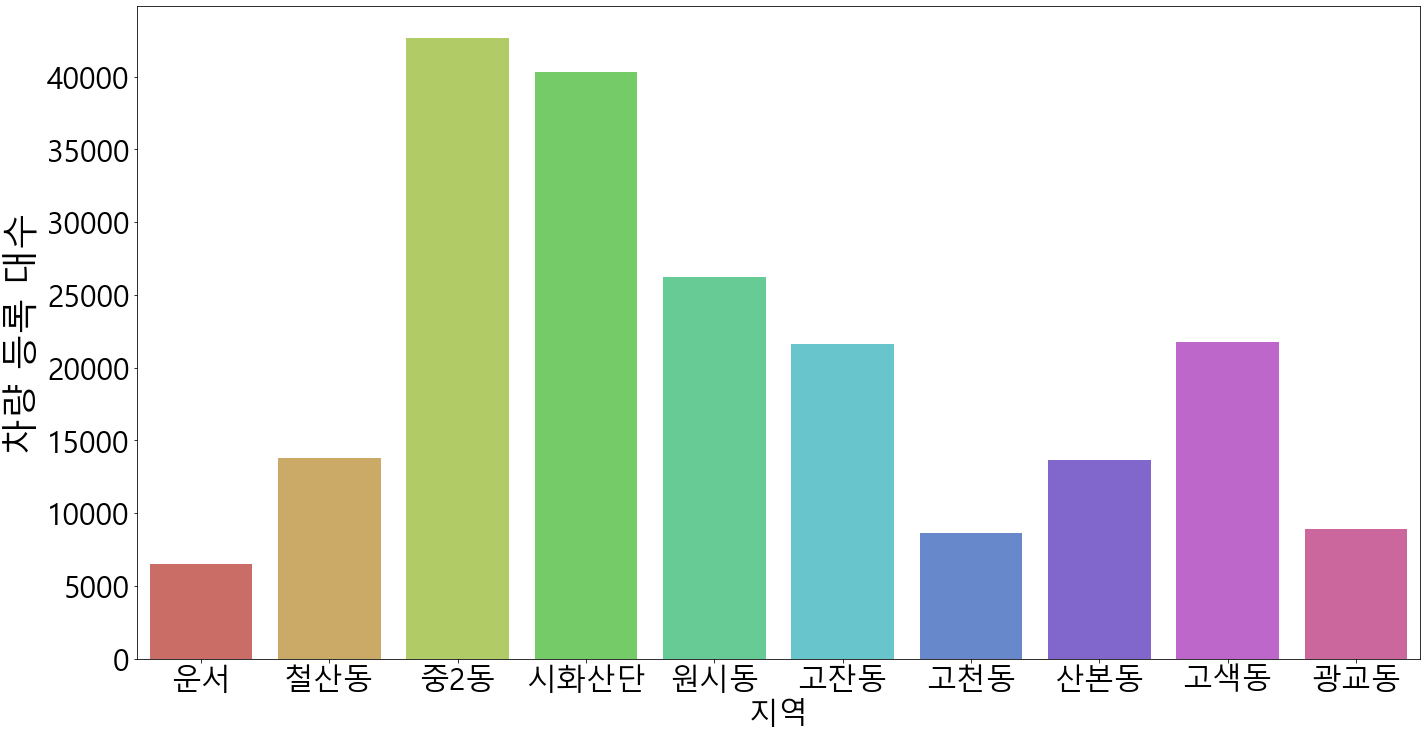

In [86]:
plt.figure(figsize=(23,12))
sns.barplot(x="site",y="car_total",palette='hls',order=site_list ,data=car_month)
plt.tick_params(labelsize=30)
plt.xlabel('지역',size=30)
plt.ylabel('차량 등록 대수',size=36)

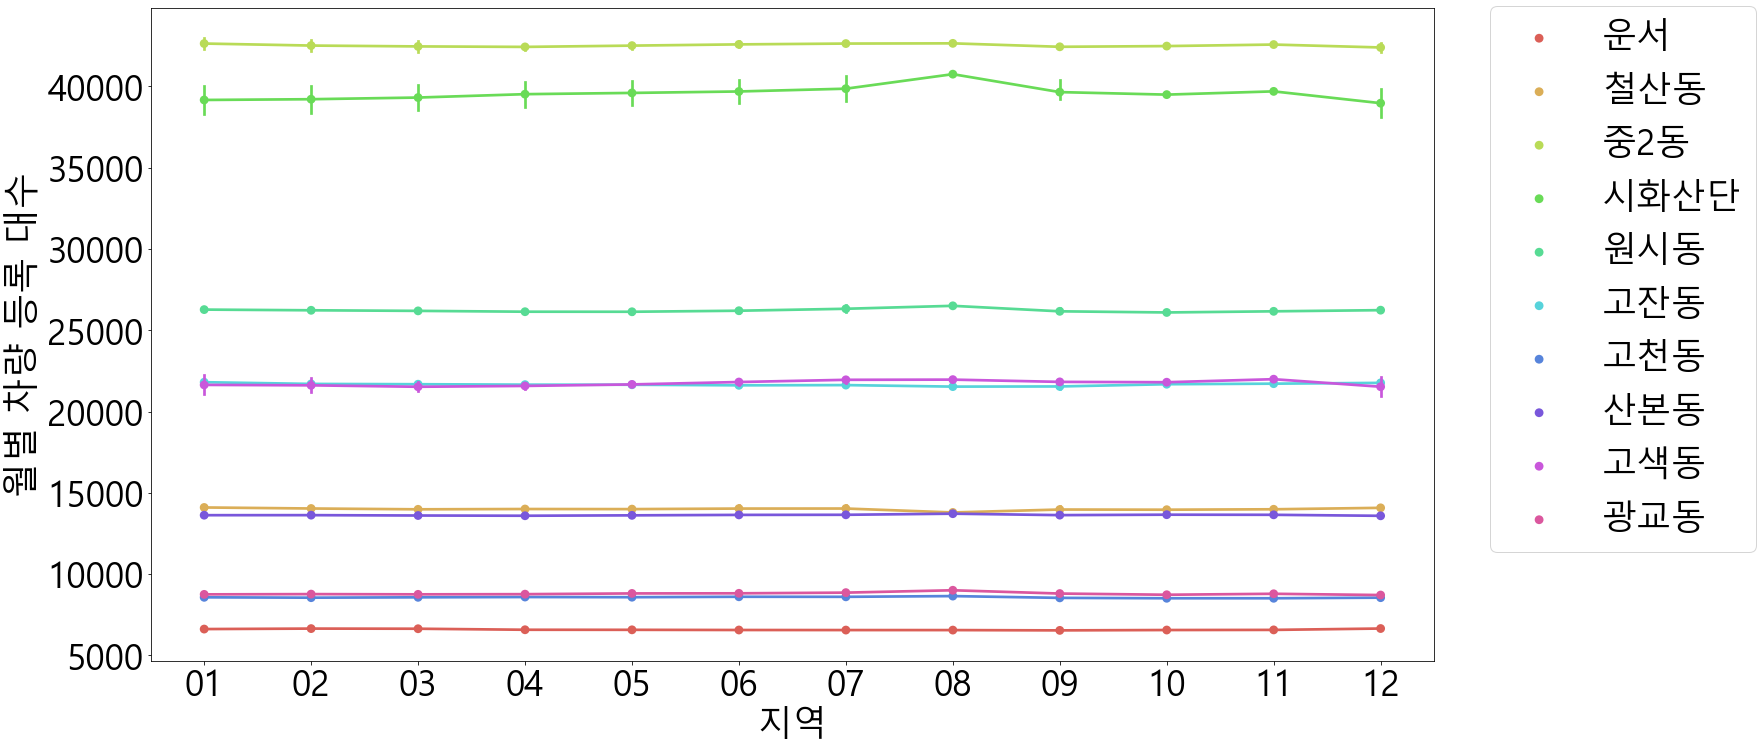

In [87]:
plt.figure(figsize=(23,12))
sns.pointplot(x="month",y="car_total", hue='site',palette='hls',hue_order=site_list ,data=car)
plt.tick_params(labelsize=35)
plt.xlabel('지역',size=35)
plt.ylabel('월별 차량 등록 대수',size=36)
plt.legend(fontsize=35,bbox_to_anchor=(1.03, 1.03))